In [215]:
from itertools import *
import math
from scipy import stats

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.mixture import GaussianMixture

from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import plot_tree

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings('ignore')

### Вероятности выпадения комбинаций на всех этапах игры

In [9]:
def C(k: int, n: int) -> int:
    return math.factorial(n)//(math.factorial(k)*math.factorial(n-k))

In [7]:
def comb_proba(ftr: int, comb: int) -> dict:
    if ftr not in [3,4,5]:
        return 'wrong round'
    
    pocket_pair = 1/17
    one_suit = 4/17
    chaos = 12/17
    pp = os = ch = 0
    
    if comb == 0: # 'high card':
        hc = (C(ftr-3+5,13)-10*C(ftr-3,8))*(C(1,4)**(ftr+2)-4**(ftr-3+1))/C(ftr+2,52)
        os = ch = hc/(one_suit+chaos)
    elif comb == 1: # 'pair':
        pp = C(ftr-3+3,12)*C(1,4)**(ftr-3+3)/C(ftr,50)
        os = ch = (C(1,3)*C(ftr-3+2,11)*C(1,4)**(ftr-3+2)*2+C(ftr-3+2,11)*C(1,4)*C(1,3)*C(1,4)**(ftr-3+1))/C(ftr,50)
    elif comb == 2: # 'two pair':
        pp = C(ftr-3+2,12)*C(1,4)*C(1,3)*C(1,4)**(ftr-3+1)/C(ftr,50)
        os = ch = (C(1,3)*C(1,3)*C(ftr-3+1,11)*C(1,4)**(ftr-3+1)+C(1,3)*C(1,11)*C(2,4)*2*C(ftr-3,47))/C(ftr,50)
    elif comb == 3: # 'three of a kind':
        pp = C(1,2)*C(ftr-3+2,12)*C(1,4)**(ftr-3+2)/C(ftr,50)
        os = ch = (C(2,3)*C(ftr-3+1,44)*2+C(1,11)*C(3,4)*C(ftr-3,47))/C(ftr,50)
    elif comb == 4: # 'straight':
        s = (C(1,10)*C(1,4)**5-C(1,10)*C(1,4))/C(ftr+2,52)*C(ftr-3,47)
        os = ch = s/(one_suit+chaos)
        if ftr != 3:
            pp = s/pocket_pair
    elif comb == 5: # 'flush':
        f = (C(5,13)*C(1,4)-C(1,10)*C(1,4))/C(ftr+2,52)*C(ftr-3,47)
        os = f/one_suit
        if ftr != 3:
            pp = f/pocket_pair
            ch = f/chaos
    elif comb == 6: # 'full house':
        pp = (C(1,12)*C(3,4)+C(1,2)*C(1,12)*C(2,4))/C(ftr,50)*C(ftr-3,44)
        os = ch = C(1,3)*C(1,3)*C(1,2)/C(ftr,50)*C(ftr-3,44)
    elif comb == 7: # 'four of a kind':
        pp = C(2,2)*C(ftr-3+1,48)/C(ftr,50)
        os = ch = C(3,3)*2/C(ftr,50)*C(ftr-3,47)
    elif comb == 8: # 'straight flush':
        sf = (C(1,10)*C(1,4)-C(1,4))/C(ftr+2,52)*C(ftr-3,47)
        os = sf/one_suit
        if ftr != 3:
            pp = sf/pocket_pair
            ch = sf/chaos
    elif comb == 9: # 'royal flush':
        rf = C(1,4)/C(ftr+2,52)*C(ftr-3,47)
        os = rf/(20/52*4/51) # определённая пара карт
        if ftr != 3:
            pp = rf/pocket_pair
            ch = rf/chaos
    else: return 'wrong combination'
    
    return {'proba': pocket_pair*pp+one_suit*os+chaos*ch, 'pocket_pair': pp, 'one_suit': os, 'chaos': ch}

### Предобработка датасета покерных рук

In [7]:
poker_data = pd.read_csv('poker_dataset.csv')
# (poker_data['result3'] == 'NOTHING').sum()
to_drop = poker_data[poker_data['result3'] == 'NOTHING'].sample(n=100000)
poker_data = poker_data.drop(to_drop.index).sample(50000)
poker_data.head()

,hand,flop,result1,turn,result2,river,result3
651053,♠6 ♠A,♠5 ♥7 ♥10,NOTHING,♠5 ♥7 ♥10 ♣7,PAIR,♠5 ♥7 ♥10 ♣7 ♠2,PAIR
886479,♣9 ♠4,♣6 ♣2 ♥2,PAIR,♣6 ♣2 ♥2 ♠6,TWO PAIR,♣6 ♣2 ♥2 ♠6 ♥3,TWO PAIR
951660,♥5 ♥A,♣K ♠A ♠2,PAIR,♣K ♠A ♠2 ♦8,PAIR,♣K ♠A ♠2 ♦8 ♠7,PAIR
487051,♦2 ♣K,♥8 ♦10 ♠5,NOTHING,♥8 ♦10 ♠5 ♣7,NOTHING,♥8 ♦10 ♠5 ♣7 ♣5,PAIR
829349,♣3 ♥10,♠7 ♠K ♦3,PAIR,♠7 ♠K ♦3 ♥J,PAIR,♠7 ♠K ♦3 ♥J ♠5,PAIR


In [9]:
poker_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 651053 to 351415
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   hand     50000 non-null  object
 1   flop     50000 non-null  object
 2   result1  50000 non-null  object
 3   turn     50000 non-null  object
 4   result2  50000 non-null  object
 5   river    50000 non-null  object
 6   result3  50000 non-null  object
dtypes: object(7)
memory usage: 3.1+ MB


In [10]:
poker_data['hand'] = poker_data['hand'].str.replace('10', 'T')
poker_data['flop'] = poker_data['flop'].str.replace('10', 'T')
poker_data['turn'] = poker_data['turn'].str.replace('10', 'T')
poker_data['river'] = poker_data['river'].str.replace('10', 'T')

poker_data[['h1_S', 'h1_C', 'h2_S', 'h2_C']] = poker_data['hand'].str.split('', expand=True).iloc[:, [1,2,4,5]]
poker_data[['S1', 'C1', 'S2', 'C2', 'S3', 'C3']] = poker_data['flop'].str.split('', expand=True).iloc[:, [1,2,4,5,7,8]]
poker_data[['S4', 'C4']] = poker_data['turn'].str.split('', expand=True).iloc[:, [10,11]]
poker_data[['S5', 'C5']] = poker_data['river'].str.split('', expand=True).iloc[:, [13,14]]
poker_data.drop(columns=['hand', 'flop', 'turn', 'river'], inplace=True)

poker_data = poker_data.rename(columns={'result1': 'result_flop'})
poker_data = poker_data.rename(columns={'result2': 'result_turn'})
poker_data = poker_data.rename(columns={'result3': 'result_river'})

poker_data.head()

,result_flop,result_turn,result_river,h1_S,h1_C,h2_S,h2_C,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5
651053,NOTHING,PAIR,PAIR,♠,6,♠,A,♠,5,♥,7,♥,T,♣,7,♠,2
886479,PAIR,TWO PAIR,TWO PAIR,♣,9,♠,4,♣,6,♣,2,♥,2,♠,6,♥,3
951660,PAIR,PAIR,PAIR,♥,5,♥,A,♣,K,♠,A,♠,2,♦,8,♠,7
487051,NOTHING,NOTHING,PAIR,♦,2,♣,K,♥,8,♦,T,♠,5,♣,7,♣,5
829349,PAIR,PAIR,PAIR,♣,3,♥,T,♠,7,♠,K,♦,3,♥,J,♠,5


In [11]:
suits = {'♣': 1, '♠': 2, '♦': 3, '♥': 4}
ranks = {'2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 'T': 10, 'J': 11, 'Q': 12, 'K': 13, 'A': 14}
results = {'NOTHING': 0, 'PAIR': 1, 'TWO PAIR': 2, 'THREE OF A KIND': 3, 'STRAIGHT': 4, 'FLUSH': 5, 'FULL HOUSE': 6, 'FOUR OF A KIND': 7,
           'STRAIGHT FLUSH': 8, 'ROYAL FLUSH': 9}

poker_data['result_flop'] = poker_data['result_flop'].map(results)
poker_data['result_turn'] = poker_data['result_turn'].map(results)
poker_data['result_river'] = poker_data['result_river'].map(results)

for column in poker_data.columns:
    if 'S' in column:
        poker_data[column] = poker_data[column].replace(suits)
for column in poker_data.columns:
    if 'C' in column:
        poker_data[column] = poker_data[column].replace(ranks)

poker_data.head()

,result_flop,result_turn,result_river,h1_S,h1_C,h2_S,h2_C,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5
651053,0,1,1,2,6,2,14,2,5,4,7,4,10,1,7,2,2
886479,1,2,2,1,9,2,4,1,6,1,2,4,2,2,6,4,3
951660,1,1,1,4,5,4,14,1,13,2,14,2,2,3,8,2,7
487051,0,0,1,3,2,1,13,4,8,3,10,2,5,1,7,1,5
829349,1,1,1,1,3,4,10,2,7,2,13,3,3,4,11,2,5


In [435]:
def determine_hand(cols: list, df: pd.DataFrame) -> pd.DataFrame:
    for index, row in df.iterrows():
        hand_ranks = [row[cols[1]], row[cols[3]]]
        hand_suits = [row[cols[0]], row[cols[2]]]
        
        if hand_suits[0] == hand_suits[1]:
            df.at[index, 'hand_result'] = 2 # one suit
        elif hand_ranks[0] == hand_ranks[1]:
            df.at[index, 'hand_result'] = 1 # pocket pair
        else:
            df.at[index, 'hand_result'] = 0 # chaos

    return df

def determine_poker_hand(cols: list, df: pd.DataFrame) -> pd.DataFrame:
    
    def has_pair(cards):
        counts = [cards.count(rank) for rank in set(cards)]
        return 2 in counts

    def has_two_pair(cards):
        counts = [cards.count(rank) for rank in set(cards)]
        return counts.count(2) >= 2

    def has_three_of_a_kind(cards):
        counts = [cards.count(rank) for rank in set(cards)]
        return 3 in counts

    def has_straight(cards):
        ranks = sorted(set(cards))
        if len(ranks) >= 5:
            for r in ranks[:-4]:
                if r+1 in ranks and r+2 in ranks and r+3 in ranks and r+4 in ranks:
                    return True
        return False

    def has_flush(suits):
        return any(suits.count(s) >= 5 for s in set(suits))

    def has_full_house(cards):
        return has_three_of_a_kind(cards) and has_pair(cards)

    def has_four_of_a_kind(cards):
        counts = [cards.count(rank) for rank in set(cards)]
        return 4 in counts

    def has_straight_flush(cards, suits):
        return has_straight(cards) and has_flush(suits)

    def has_royal_flush(cards, suits):
        return has_straight_flush(cards, suits) and set(cards) == {10, 11, 12, 13, 14}

    for index, row in df.iterrows():
        hand_ranks = [row[cols[1]], row[cols[3]], row[cols[5]], row[cols[7]], row[cols[9]]]
        hand_suits = [row[cols[0]], row[cols[2]], row[cols[4]], row[cols[6]], row[cols[8]]]
        if len(cols) == 12:
            hand_ranks = hand_ranks + [row[cols[11]]]
            hand_suits = hand_suits + [row[cols[10]]]
        elif len(cols) == 14:
            hand_ranks = hand_ranks + [row[cols[11]], row[cols[13]]]
            hand_suits = hand_suits + [row[cols[10]], row[cols[12]]]

        if has_royal_flush(hand_ranks, hand_suits):
            df.at[index, 'result'] = 9
        elif has_straight_flush(hand_ranks, hand_suits):
            df.at[index, 'result'] = 8
        elif has_four_of_a_kind(hand_ranks):
            df.at[index, 'result'] = 7
        elif has_full_house(hand_ranks):
            df.at[index, 'result'] = 6
        elif has_flush(hand_suits):
            df.at[index, 'result'] = 5
        elif has_straight(hand_ranks):
            df.at[index, 'result'] = 4
        elif has_three_of_a_kind(hand_ranks):
            df.at[index, 'result'] = 3
        elif has_two_pair(hand_ranks):
            df.at[index, 'result'] = 2
        elif has_pair(hand_ranks):
            df.at[index, 'result'] = 1
        else:
            df.at[index, 'result'] = 0

    return df

### Оценка комбинаций соперников

In [7]:
print("flop rivals' pairs: ", C(2,47), "\nturn rivals' pairs: ", C(2,46), "\nriver rivals' pairs: ", C(2,45))

flop rivals' pairs:  1081 
turn rivals' pairs:  1035 
river rivals' pairs:  990


In [10]:
cards_data3 = poker_data[['h1_S', 'h1_C', 'h2_S', 'h2_C', 'S1', 'C1', 'S2', 'C2', 'S3', 'C3']]
cards_data4 = poker_data[['h1_S', 'h1_C', 'h2_S', 'h2_C', 'S1', 'C1', 'S2', 'C2', 'S3', 'C3', 'S4', 'C4']]
cards_data5 = poker_data[['h1_S', 'h1_C', 'h2_S', 'h2_C', 'S1', 'C1', 'S2', 'C2', 'S3', 'C3', 'S4', 'C4', 'S5', 'C5']]
cards_data5.head()

,h1_S,h1_C,h2_S,h2_C,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5
13759,1,9,2,4,1,5,1,2,3,11,2,3,3,6
674217,3,5,3,3,3,6,3,14,1,8,2,5,3,7
688005,1,12,1,8,3,10,4,8,4,10,2,10,1,14
911603,4,5,2,11,1,14,2,12,3,11,4,13,3,14
678320,3,12,2,13,4,7,4,2,4,13,1,5,2,6


In [436]:
def make_comb_options(table: dict) -> pd.DataFrame:
    # cards = {key: [1,2,3,4] for key in range(2,15)}
    cards = [(s,c) for s in range(1,5) for c in range(2,15)]  # возможные карты у соперника (надо удалить известные)
    
    cards.remove((table['h1_S'], table['h1_C']))
    cards.remove((table['h2_S'], table['h2_C']))
    cards.remove((table['S1'], table['C1']))
    cards.remove((table['S2'], table['C2']))
    cards.remove((table['S3'], table['C3']))
    if 'S4' and 'C4' in table.keys():
        cards.remove((table['S4'], table['C4']))
    if 'S5' and 'C5' in table.keys():
        cards.remove((table['S5'], table['C5']))
        
    hand_opts = list(combinations([_ for _ in cards], 2)) # варианты рук соперника
    len_ho = len(hand_opts)
    
    opts = {'h1_S': [], 'h1_C': [], 'h2_S': [], 'h2_C': [], 'S1': [table['S1']]*len_ho, 'C1': [table['C1']]*len_ho, 'S2': [table['S2']]*len_ho,
            'C2': [table['C2']]*len_ho, 'S3': [table['S3']]*len_ho, 'C3': [table['C3']]*len_ho}
    if 'S4' and 'C4' in table.keys():
        opts['S4'] = [table['S4']]*len_ho
        opts['C4'] = [table['C4']]*len_ho
    if 'S5' and 'C5' in table.keys():
        opts['S5'] = [table['S5']]*len_ho
        opts['C5'] = [table['C5']]*len_ho
        
    for hand in hand_opts:
        opts['h1_S'].append(hand[0][0])
        opts['h1_C'].append(hand[0][1])
        opts['h2_S'].append(hand[1][0])
        opts['h2_C'].append(hand[1][1])
        
    return pd.DataFrame(opts)

In [37]:
table3 = cards_data3.iloc[32934].to_dict()
opts_data3 = make_comb_options(table3) # возможные комбинации соперника на флопе

table4 = cards_data4.iloc[32934].to_dict()
opts_data4 = make_comb_options(table4) # возможные комбинации соперника на тёрне

table5 = cards_data5.iloc[32934].to_dict()
opts_data5 = make_comb_options(table5) # возможные комбинации соперника на ривере

opts_data5

,h1_S,h1_C,h2_S,h2_C,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5
0,1,3,1,4,4,10,1,11,1,2,2,12,2,9
1,1,3,1,5,4,10,1,11,1,2,2,12,2,9
2,1,3,1,6,4,10,1,11,1,2,2,12,2,9
3,1,3,1,7,4,10,1,11,1,2,2,12,2,9
4,1,3,1,8,4,10,1,11,1,2,2,12,2,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,4,9,4,13,4,10,1,11,1,2,2,12,2,9
986,4,9,4,14,4,10,1,11,1,2,2,12,2,9
987,4,12,4,13,4,10,1,11,1,2,2,12,2,9
988,4,12,4,14,4,10,1,11,1,2,2,12,2,9


In [115]:
pred3 = determine_poker_hand(['h1_S', 'h1_C', 'h2_S', 'h2_C', 'S1', 'C1', 'S2', 'C2', 'S3', 'C3'], opts_data3)['result'].values
pred4 = determine_poker_hand(['h1_S', 'h1_C', 'h2_S', 'h2_C', 'S1', 'C1', 'S2', 'C2', 'S3', 'C3', 'S4', 'C4'], opts_data4)['result'].values
pred5 = determine_poker_hand(['h1_S', 'h1_C', 'h2_S', 'h2_C', 'S1', 'C1', 'S2', 'C2', 'S3', 'C3', 'S4', 'C4', 'S5', 'C5'], opts_data5)['result'].values

comb = np.unique(pred3, return_counts=True)
print(comb[0], comb[1]/comb[1].sum()) # возможные комбинации соперника и их вероятности
print(stats.mode(pred3)[0][0]) # наиболее вероятная комбинация соперника

comb = np.unique(pred4, return_counts=True)
print(comb[0], comb[1]/comb[1].sum()) # возможные комбинации соперника и их вероятности
print(stats.mode(pred4)[0][0]) # наиболее вероятная комбинация соперника

comb = np.unique(pred5, return_counts=True)
print(comb[0], comb[1]/comb[1].sum()) # возможные комбинации соперника и их вероятности
print(stats.mode(pred5)[0][0]) # наиболее вероятная комбинация соперника

[0. 1. 2. 3.] [0.63274746 0.3413506  0.01942646 0.00647549]
0.0
[0. 1. 2. 3. 4. 5. 8.] [0.48019324 0.41256039 0.04347826 0.00966184 0.01062802 0.04251208
 0.00096618]
0.0
[0. 1. 2. 3. 4. 5. 8.] [0.36969697 0.46767677 0.07777778 0.01313131 0.02626263 0.04343434
 0.0020202 ]
1.0


### Расчёт силы карты

$$HS = \frac{wins + \frac{ties}{2}}{wins + ties + losses}$$

In [437]:
def HS(table: dict) -> float:
    opts_data = make_comb_options(table)
    combs = pd.concat([pd.DataFrame([table]), opts_data], ignore_index=True)
    combs = determine_poker_hand(['h1_S', 'h1_C', 'h2_S', 'h2_C', 'S1', 'C1', 'S2', 'C2', 'S3', 'C3'], combs)
    
    myres = combs.iloc[0]['result']
    wins, losses = combs[combs['result'] < myres].shape[0], combs[combs['result'] > myres].shape[0]
    ties = 0
    
    combs = combs[combs['result'] == myres]
    table_C = [table['h1_C'], table['h2_C'], table['C1'], table['C2'], table['C3']]
    for index, row in combs[1:].iterrows():
        row_C = [row['h1_C'], row['h2_C'], row['C1'], row['C2'], row['C3']]
        if myres == 0:
            if np.max([table['h1_C'], table['h2_C']]) == np.max([row['h1_C'], row['h2_C']]):
                ties += 1
            elif np.max([table['h1_C'], table['h2_C']]) < np.max([row['h1_C'], row['h2_C']]):
                losses += 1
            else:
                wins += 1
        elif myres == 1:
            mode1 = stats.mode(table_C)[0][0]
            mode2 = stats.mode(row_C)[0][0]
            if mode1 == mode2:
                ties += 1
            elif mode1 < mode2:
                losses += 1
            else:
                wins += 1
        elif myres == 2:
            mode11 = stats.mode(table_C)[0][0]
            mode12 = stats.mode(row_C)[0][0]
            mode21 = stats.mode([t for t in table_C if t != mode11])[0][0]
            mode22 = stats.mode([r for r in row_C if r != mode12])[0][0]
            if (mode11 == mode12) and (mode21 == mode22):
                ties += 1
            elif (mode21 < mode22) or (mode21 == mode22 and mode11 < mode12):
                losses += 1
            else:
                wins += 1
        elif myres == 3:
            mode1 = stats.mode(table_C)[0][0]
            mode2 = stats.mode(row_C)[0][0]
            if mode1 == mode2:
                ties += 1
            elif mode1 < mode2:
                losses += 1
            else:
                wins += 1
        elif myres == 4:
            sum1 = np.sum(table_C)
            sum2 = np.sum(row_C)
            if sum1 == sum2:
                ties += 1
            elif sum1 < sum2:
                losses += 1
            else:
                wins += 1
        elif myres == 5:
            sum1 = np.sum(table_C)
            sum2 = np.sum(row_C)
            if sum1 < sum2:
                losses += 1
            else:
                wins += 1
        elif myres == 6:
            mode1 = stats.mode(table_C)[0][0]
            mode2 = stats.mode(row_C)[0][0]
            sum1 = np.sum(table_C)
            sum2 = np.sum(row_C)
            if sum1 == sum2:
                ties += 1
            elif (mode1 < mode2) or (mode1 == mode2 and sum1 < sum2):
                losses += 1
            else:
                wins += 1
        elif myres == 8:
            sum1 = np.sum(table_C)
            sum2 = np.sum(row_C)
            if sum1 < sum2:
                losses += 1
            else:
                wins += 1
    return (wins + ties/2) / (wins + ties + losses)

In [438]:
HS({'h1_S': 2, 'h1_C': 14, 'h2_S': 2, 'h2_C': 7, 'S1': 3, 'C1': 8, 'S2': 4, 'C2': 14, 'S3': 4, 'C3': 9})

0.9380203515263644

$$EHS = HS(1 − NPOT) + (1 − HS)PPOT$$

In [439]:
def EHS(cards: dict) -> float:
    if 'S5' in cards.keys():
        l = 14
    elif 'S4' in cards.keys():
        l = 12
    else:
        l = 10
        
    if l == 10:
        keys = ['h1_S', 'h1_C', 'h2_S', 'h2_C', 'S1', 'C1', 'S2', 'C2', 'S3', 'C3']
    elif l == 12:
        keys = ['h1_S', 'h1_C', 'h2_S', 'h2_C', 'S1', 'C1', 'S2', 'C2', 'S3', 'C3', 'S4', 'C4']
    elif l == 14:
        keys = ['h1_S', 'h1_C', 'h2_S', 'h2_C', 'S1', 'C1', 'S2', 'C2', 'S3', 'C3', 'S4', 'C4', 'S5', 'C5']
    HPTotal = [0, 0, 0]  # массив для хранения количества побед, ничьих и поражений на флопе
    HP = [[0, 0, 0], [0, 0, 0], [0, 0, 0]]  # массив для хранения результатов после флопа
    
    ourbest = int(determine_poker_hand(keys, pd.DataFrame([cards]))['result'])
    
    opts_data = make_comb_options(cards)
    pred = determine_poker_hand(keys, opts_data)
    HPTotal = [pred[pred['result']<ourbest].shape[0], pred[pred['result']==ourbest].shape[0], pred[pred['result']>ourbest].shape[0]] # победы, ничьи, поражения
    opts_data = opts_data.drop(columns=['result'])
    
    tr = [(s,c) for s in range(1,5) for c in range(2,15)]  # возможные карты тёрна и ривера (надо удалить известные)
    tr.remove((cards['h1_S'], cards['h1_C']))
    tr.remove((cards['h2_S'], cards['h2_C']))
    tr.remove((cards['S1'], cards['C1']))
    tr.remove((cards['S2'], cards['C2']))
    tr.remove((cards['S3'], cards['C3']))
    if l == 12:
        tr.remove((cards['S4'], cards['C4']))
    elif l == 14:
        tr.remove((cards['S4'], cards['C4']))
        tr.remove((cards['S5'], cards['C5']))
        
    for i in range(opts_data.shape[0]): #for index, row in opts_data.iterrows():
        row = pd.DataFrame([opts_data.iloc[i].to_dict()])
        oppbest = int(determine_poker_hand(keys, pd.DataFrame(row))['result'])
        if ourbest > oppbest:
            index = 0
        elif ourbest == oppbest:
            index = 1
        else:
            index = 2
        
        tr.remove((int(row['h1_S']), int(row['h1_C'])))
        tr.remove((int(row['h2_S']), int(row['h2_C'])))
        if l == 10:
            tr_opts = list(combinations([_ for _ in tr], 2)) # варианты тёрна и ривера
            len_tr = len(tr_opts)
        elif l == 12:
            len_tr = len(tr)
        elif l == 14:
            len_tr = 1

        opts = {'ourh1_S': [cards['h1_S']]*len_tr, 'ourh1_C': [cards['h1_C']]*len_tr, 'ourh2_S': [cards['h2_S']]*len_tr, 'ourh2_C': [cards['h2_C']]*len_tr,
                'h1_S': [int(row['h1_S'])]*len_tr, 'h1_C': [int(row['h1_C'])]*len_tr, 'h2_S': [int(row['h2_S'])]*len_tr, 'h2_C': [int(row['h2_C'])]*len_tr,
                'S1': [int(row['S1'])]*len_tr, 'C1': [int(row['C1'])]*len_tr, 'S2': [int(row['S2'])]*len_tr, 'C2': [int(row['C2'])]*len_tr,
                'S3': [int(row['S3'])]*len_tr, 'C3': [int(row['C3'])]*len_tr}
        if l == 10:
            opts['S4'] = []
            opts['C4'] = []
            opts['S5'] = []
            opts['C5'] = []
            for o in tr_opts:
                opts['S4'].append(o[0][0])
                opts['C4'].append(o[0][1])
                opts['S5'].append(o[1][0])
                opts['C5'].append(o[1][1])
        elif l == 12:
            opts['S4'] = [int(row['S4'])]*len_tr
            opts['C4'] = [int(row['C4'])]*len_tr
            opts['S5'] = []
            opts['C5'] = []
            for o in tr:
                opts['S5'].append(o[0])
                opts['C5'].append(o[1])
        elif l == 14:
            opts['S4'] = [int(row['S4'])]*len_tr
            opts['C4'] = [int(row['C4'])]*len_tr
            opts['S5'] = [int(row['S5'])]*len_tr
            opts['C5'] = [int(row['C5'])]*len_tr
            
                
        final_opts = pd.DataFrame(opts)
        determine_poker_hand(['ourh1_S', 'ourh1_C', 'ourh2_S', 'ourh2_C', 'S1', 'C1', 'S2', 'C2', 'S3', 'C3', 'S4', 'C4', 'S5', 'C5'], final_opts)
        final_opts.rename(columns={'result': 'ourresult'}, inplace=True)
        determine_poker_hand(['h1_S', 'h1_C', 'h2_S', 'h2_C', 'S1', 'C1', 'S2', 'C2', 'S3', 'C3', 'S4', 'C4', 'S5', 'C5'], final_opts)
        sh = final_opts.shape[0]
        HP[index][0] += final_opts[final_opts['ourresult']>final_opts['result']].shape[0]/sh
        HP[index][1] += final_opts[final_opts['ourresult']==final_opts['result']].shape[0]/sh
        HP[index][2] += final_opts[final_opts['ourresult']<final_opts['result']].shape[0]/sh
        
        tr = tr + [(int(row['h1_S']), int(row['h1_C']))] + [(int(row['h2_S']), int(row['h2_C']))]
    
    if HPTotal[2] + HPTotal[1] == 0:
        PPOT = (HP[2][0] + HP[2][1]/2 + HP[1][0]/2)
    else:
        PPOT = (HP[2][0] + HP[2][1]/2 + HP[1][0]/2) / (HPTotal[2] + HPTotal[1])
    if HPTotal[0] + HPTotal[1] == 0:
        NPOT = (HP[0][2] + HP[1][2]/2 + HP[0][1]/2)
    else:
        NPOT = (HP[0][2] + HP[1][2]/2 + HP[0][1]/2) / (HPTotal[0] + HPTotal[1])
    hs = HS(cards)
    return hs*(1-NPOT) + (1-hs)*PPOT

In [140]:
EHS({'h1_S': 2, 'h1_C': 14, 'h2_S': 2, 'h2_C': 7, 'S1': 3, 'C1': 8, 'S2': 4, 'C2': 14, 'S3': 4, 'C3': 9})

0.7943687540729726

In [141]:
EHS({'h1_S': 2, 'h1_C': 14, 'h2_S': 2, 'h2_C': 7, 'S1': 3, 'C1': 8, 'S2': 4, 'C2': 14, 'S3': 4, 'C3': 9, 'S4': 2, 'C4': 5})

0.867198388518831

In [139]:
EHS({'h1_S': 2, 'h1_C': 14, 'h2_S': 2, 'h2_C': 7, 'S1': 3, 'C1': 8, 'S2': 4, 'C2': 14, 'S3': 4, 'C3': 9, 'S4': 2, 'C4': 5, 'S5': 1, 'C5': 14})

0.9595959595959596

### Предобработка датасетов партий в онлайн-покер

In [78]:
col_names = ['ID', 'Round', 'GameID', 'NumPlayers', 'Rate1', 'Rate2', 'Rate3', 'Rate4', '1', '2', '3', '4', '5']
hdb = pd.read_csv('hdb', sep='\s+', names=col_names)
hdb = hdb.loc[hdb['NumPlayers'] <= 4]
hdb = hdb.drop(columns=['Round', 'GameID'])
hdb[['Rate1', 'Rate2', 'Rate3', 'Rate4', '1', '2', '3', '4', '5']] = hdb[['Rate1', 'Rate2', 'Rate3', 'Rate4', '1', '2', '3', '4', '5']].astype(str)

hdb['1'] = hdb['1'].str.replace('nan', 'nn')
hdb['2'] = hdb['2'].str.replace('nan', 'nn')
hdb['3'] = hdb['3'].str.replace('nan', 'nn')
hdb['4'] = hdb['4'].str.replace('nan', 'nn')
hdb['5'] = hdb['5'].str.replace('nan', 'nn')
hdb[['S1', 'C1']] = hdb['1'].str.split('', expand=True).iloc[:, [2,1]]
hdb[['S2', 'C2']] = hdb['2'].str.split('', expand=True).iloc[:, [2,1]]
hdb[['S3', 'C3']] = hdb['3'].str.split('', expand=True).iloc[:, [2,1]]
hdb[['S4', 'C4']] = hdb['4'].str.split('', expand=True).iloc[:, [2,1]]
hdb[['S5', 'C5']] = hdb['5'].str.split('', expand=True).iloc[:, [2,1]]
hdb = hdb.drop(columns=['1', '2', '3', '4', '5'])

suits = {'c': 1, 's': 2, 'd': 3, 'h': 4, 'n': 'nan'}
ranks = {'2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 'T': 10, 'J': 11, 'Q': 12, 'K': 13, 'A': 14, 'n': 'nan'}
for column in hdb.columns:
    if 'S' in column:
        hdb[column] = hdb[column].replace(suits)
for column in hdb.columns:
    if 'C' in column:
        hdb[column] = hdb[column].replace(ranks)
        
hdb2 = hdb.loc[hdb['NumPlayers'] == 2]
hdb3 = hdb.loc[hdb['NumPlayers'] == 3]
hdb4 = hdb.loc[hdb['NumPlayers'] == 4]
hdb

,ID,NumPlayers,Rate1,Rate2,Rate3,Rate4,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5
199,797228539,4,2/25,2/25,0/0,1/45,1,9,4,14,1,5,4,11,nan,nan
200,797228610,4,2/40,2/40,2/40,2/40,2,8,1,2,4,2,3,4,1,9
201,797228652,2,2/20,2/20,0/0,0/40,2,7,2,8,1,2,1,10,nan,nan
202,797233613,2,0/0,0/0,0/0,1/15,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
203,797233616,2,2/20,0/0,0/0,0/30,4,3,4,14,1,6,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27536,799297459,3,2/20,0/0,0/0,1/30,1,3,1,7,4,14,nan,nan,nan,nan
27537,799297836,2,0/0,0/0,0/0,0/15,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
27538,799306282,3,0/0,0/0,0/0,1/25,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
27539,799306497,2,2/20,2/20,0/0,1/1920,1,8,3,10,3,2,2,12,nan,nan


In [79]:
col_names = ['ID', 'NumPlayers'] + [f'Player{i}' for i in range(1, 13)]
hroster = pd.read_csv('hroster', sep='\s+', names=col_names)
hroster = hroster.fillna('nan')
hroster.head()

,ID,NumPlayers,Player1,Player2,Player3,Player4,Player5,Player6,Player7,Player8,Player9,Player10,Player11,Player12
0,797210868,9,Quick,Winner777,derek,greg,gunner,jims,johnr,sagerbot,shinner,nan,nan,nan
1,797210948,8,Winner777,derek,greg,gunner,jims,johnr,sagerbot,shinner,nan,nan,nan,nan
2,797211062,8,Winner777,deadhead,derek,greg,gunner,jims,sagerbot,shinner,nan,nan,nan,nan
3,797211160,7,deadhead,derek,greg,gunner,jims,sagerbot,shinner,nan,nan,nan,nan,nan
4,797211251,7,deadhead,derek,greg,gunner,jims,sagerbot,shinner,nan,nan,nan,nan,nan


In [80]:
game_players = pd.merge(hdb, hroster, how='inner', left_on='ID', right_on='ID', suffixes=('', '_y'))
game_players.drop(columns=['NumPlayers_y'], inplace=True)
game_players = game_players.drop(columns=[f'Player{i}' for i in range(5, 13)])

game_players2 = game_players[game_players['NumPlayers'] == 2]
game_players3 = game_players[game_players['NumPlayers'] == 3]
game_players4 = game_players[game_players['NumPlayers'] == 4]
game_players.head()

,ID,NumPlayers,Rate1,Rate2,Rate3,Rate4,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5,Player1,Player2,Player3,Player4
0,797228539,4,2/25,2/25,0/0,1/45,1,9,4,14,1,5,4,11,nan,nan,EdK,Matilda,Raybould,oejack
1,797228610,4,2/40,2/40,2/40,2/40,2,8,1,2,4,2,3,4,1,9,EdK,Matilda,Raybould,oejack
2,797228652,2,2/20,2/20,0/0,0/40,2,7,2,8,1,2,1,10,nan,nan,Matilda,Raybould,nan,nan
3,797233613,2,0/0,0/0,0/0,1/15,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,jzk,jzkbot,nan,nan
4,797233616,2,2/20,0/0,0/0,0/30,4,3,4,14,1,6,nan,nan,nan,nan,jzk,jzkbot,nan,nan


In [81]:
col = [f'Player{i}' for i in range(1, 5)]
val = []
for c in col:
    val.extend(game_players[c])
players = list(val)
sorted(np.transpose(np.unique(players, return_counts=True)), key=lambda x: x[1].astype('int'), reverse=True)[1:11] # играют чаще всего

[array(['perfecto', '2097'], dtype='<U21'),
 array(['leo', '1782'], dtype='<U21'),
 array(['wsk', '1518'], dtype='<U21'),
 array(['sagerbot', '1491'], dtype='<U21'),
 array(['horseplay', '1088'], dtype='<U21'),
 array(['The_Big_H', '992'], dtype='<U21'),
 array(['tvp', '985'], dtype='<U21'),
 array(['alfalfa', '957'], dtype='<U21'),
 array(['ab0', '921'], dtype='<U21'),
 array(['Lev', '707'], dtype='<U21')]

In [82]:
def player(file_name: str) -> pd.DataFrame:
    col_names = ['Name', 'ID', 'NumPlayers', 'TablePosition', 'PreFlop', 'Flop', 'Turn', 'River', 'PotSize', 'TotalRate', 'Won', 'h1', 'h2']
    p = pd.read_csv(file_name, sep='\s+', names=col_names)
    p = p.drop(columns=['NumPlayers']) #, 'TablePosition'])
    #p = p.dropna(subset=['h1', 'h2']) делать перед каждым кругом торгов

    p['Flop'] = p['Flop'].str.replace('-', 'nan')
    p['Turn'] = p['Turn'].str.replace('-', 'nan')
    p['River'] = p['River'].str.replace('-', 'nan')
    p = p.fillna('nn')

    p[['h1_S', 'h1_C']] = p['h1'].str.split('', expand=True).iloc[:, [2,1]]
    p[['h2_S', 'h2_C']] = p['h2'].str.split('', expand=True).iloc[:, [2,1]]
    p = p.drop(columns=['h1', 'h2'])

    for column in p.columns:
        if 'S' in column:
            p[column] = p[column].replace(suits)
    for column in p.columns:
        if 'C' in column:
            p[column] = p[column].replace(ranks)
    return p

In [83]:
pd.Series(zip(game_players2['Player1'], game_players2['Player2'])).value_counts().head(15)

(leo, wsk)              525
(perfecto, tvp)         483
(jzkbot, rktbot)        340
(alfalfa, perfecto)     272
(conrad, godot)         230
(IFR, wsk)              149
(WildCard, sagerbot)    125
(slap, whiz2)           121
(beauzeau, perfecto)    105
(alfalfa, tvp)          102
(Shooter, wsk)           96
(ElDave, badbeat)        95
(deadhead, perfecto)     94
(Sakthi, badbeat)        93
(jims, perfecto)         83
dtype: int64

In [84]:
perfecto = player('pdb/pdb.perfecto')
leo = player('pdb/pdb.leo')
wsk = player('pdb/pdb.wsk')
sagerbot = player('pdb/pdb.sagerbot')
tvp = player('pdb/pdb.tvp')
alfalfa = player('pdb/pdb.alfalfa')
jzkbot = player('pdb/pdb.jzkbot')
rktbot = player('pdb/pdb.rktbot')
conrad = player('pdb/pdb.conrad')
godot = player('pdb/pdb.godot')
IFR = player('pdb/pdb.IFR')
WildCard = player('pdb/pdb.WildCard')
slap = player('pdb/pdb.slap')
whiz2 = player('pdb/pdb.whiz2')
beauzeau = player('pdb/pdb.beauzeau')
Shooter = player('pdb/pdb.Shooter')
ElDave = player('pdb/pdb.ElDave')
badbeat = player('pdb/pdb.badbeat')
deadhead = player('pdb/pdb.deadhead')
Sakthi = player('pdb/pdb.Sakthi')
jims = player('pdb/pdb.beauzeau')

perfecto.head()

,Name,ID,TablePosition,PreFlop,Flop,Turn,River,PotSize,TotalRate,Won,h1_S,h1_C,h2_S,h2_C
0,perfecto,797696138,2,Bk,f,nan,nan,1000,10,0,nan,nan,nan,nan
1,perfecto,797696151,1,Bc,b,nan,nan,990,20,30,nan,nan,nan,nan
2,perfecto,797696163,2,Bk,k,k,k,1000,10,0,2,2,4,7
3,perfecto,797696182,1,Bf,nan,nan,nan,990,5,0,nan,nan,nan,nan
4,perfecto,797696185,2,Bc,k,f,nan,985,20,0,nan,nan,nan,nan


In [25]:
p1 = pd.merge(hdb2, leo, how='inner', left_on='ID', right_on='ID')
p1 = pd.merge(p1, wsk, how='inner', left_on='ID', right_on='ID')

p2 = pd.merge(hdb2, perfecto, how='inner', left_on='ID', right_on='ID')
p2 = pd.merge(p2, tvp, how='inner', left_on='ID', right_on='ID')

p3 = pd.merge(hdb2, jzkbot, how='inner', left_on='ID', right_on='ID')
p3 = pd.merge(p3, rktbot, how='inner', left_on='ID', right_on='ID')

p4 = pd.merge(hdb2, alfalfa, how='inner', left_on='ID', right_on='ID')
p4 = pd.merge(p4, perfecto, how='inner', left_on='ID', right_on='ID')

p5 = pd.merge(hdb2, conrad, how='inner', left_on='ID', right_on='ID')
p5 = pd.merge(p5, godot, how='inner', left_on='ID', right_on='ID')

p6 = pd.merge(hdb2, IFR, how='inner', left_on='ID', right_on='ID')
p6 = pd.merge(p6, wsk, how='inner', left_on='ID', right_on='ID')

p7 = pd.merge(hdb2, WildCard, how='inner', left_on='ID', right_on='ID')
p7 = pd.merge(p7, sagerbot, how='inner', left_on='ID', right_on='ID')

p8 = pd.merge(hdb2, slap, how='inner', left_on='ID', right_on='ID')
p8 = pd.merge(p8, whiz2, how='inner', left_on='ID', right_on='ID')

p9 = pd.merge(hdb2, beauzeau, how='inner', left_on='ID', right_on='ID')
p9 = pd.merge(p9, perfecto, how='inner', left_on='ID', right_on='ID')

p10 = pd.merge(hdb2, alfalfa, how='inner', left_on='ID', right_on='ID')
p10 = pd.merge(p10, tvp, how='inner', left_on='ID', right_on='ID')

p11 = pd.merge(hdb2, Shooter, how='inner', left_on='ID', right_on='ID')
p11 = pd.merge(p11, wsk, how='inner', left_on='ID', right_on='ID')

p12 = pd.merge(hdb2, ElDave, how='inner', left_on='ID', right_on='ID')
p12 = pd.merge(p12, badbeat, how='inner', left_on='ID', right_on='ID')

p13 = pd.merge(hdb2, deadhead, how='inner', left_on='ID', right_on='ID')
p13 = pd.merge(p13, perfecto, how='inner', left_on='ID', right_on='ID')

p14 = pd.merge(hdb2, Sakthi, how='inner', left_on='ID', right_on='ID')
p14 = pd.merge(p14, badbeat, how='inner', left_on='ID', right_on='ID')

p15 = pd.merge(hdb2, jims, how='inner', left_on='ID', right_on='ID')
p15 = pd.merge(p15, perfecto, how='inner', left_on='ID', right_on='ID')

poker2 = pd.concat([p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12, p13, p14, p15], ignore_index=True)
poker2.to_csv("poker2.csv", index=False)

In [26]:
folds = poker2[poker2['h1_S_x']=='nan']
poker2 = poker2[poker2['h1_S_x']!='nan']
poker2 = poker2.reset_index(drop=True)

In [27]:
determine_hand(['h1_S_x', 'h1_C_x', 'h2_S_x', 'h2_C_x'], poker2)
poker2.rename(columns={'hand_result': 'hand_x'}, inplace=True)
poker2.insert(loc=25, column='hand_x', value=poker2.pop('hand_x'))

determine_poker_hand(['h1_S_x', 'h1_C_x', 'h2_S_x', 'h2_C_x', 'S1', 'C1', 'S2', 'C2', 'S3', 'C3'], poker2)
poker2.rename(columns={'result': 'res_flop_x'}, inplace=True)
poker2.insert(loc=26, column='res_flop_x', value=poker2.pop('res_flop_x'))

determine_poker_hand(['h1_S_x', 'h1_C_x', 'h2_S_x', 'h2_C_x', 'S1', 'C1', 'S2', 'C2', 'S3', 'C3', 'S4', 'C4'], poker2)
poker2.rename(columns={'result': 'res_turn_x'}, inplace=True)
poker2.insert(loc=27, column='res_turn_x', value=poker2.pop('res_turn_x'))

determine_poker_hand(['h1_S_x', 'h1_C_x', 'h2_S_x', 'h2_C_x', 'S1', 'C1', 'S2', 'C2', 'S3', 'C3', 'S4', 'C4', 'S5', 'C5'], poker2)
poker2.rename(columns={'result': 'res_river_x'}, inplace=True)
poker2.insert(loc=28, column='res_river_x', value=poker2.pop('res_river_x'))
#poker2 = poker2.drop(columns=['h1_S_x', 'h1_C_x', 'h2_S_x', 'h2_C_x'])


determine_hand(['h1_S_y', 'h1_C_y', 'h2_S_y', 'h2_C_y'], poker2)
poker2.rename(columns={'hand_result': 'hand_y'}, inplace=True)
poker2.insert(loc=42, column='hand_y', value=poker2.pop('hand_y'))

determine_poker_hand(['h1_S_y', 'h1_C_y', 'h2_S_y', 'h2_C_y', 'S1', 'C1', 'S2', 'C2', 'S3', 'C3'], poker2)
poker2.rename(columns={'result': 'res_flop_y'}, inplace=True)
poker2.insert(loc=43, column='res_flop_y', value=poker2.pop('res_flop_y'))

determine_poker_hand(['h1_S_y', 'h1_C_y', 'h2_S_y', 'h2_C_y', 'S1', 'C1', 'S2', 'C2', 'S3', 'C3', 'S4', 'C4'], poker2)
poker2.rename(columns={'result': 'res_turn_y'}, inplace=True)
poker2.insert(loc=44, column='res_turn_y', value=poker2.pop('res_turn_y'))

determine_poker_hand(['h1_S_y', 'h1_C_y', 'h2_S_y', 'h2_C_y', 'S1', 'C1', 'S2', 'C2', 'S3', 'C3', 'S4', 'C4', 'S5', 'C5'], poker2)
poker2.rename(columns={'result': 'res_river_y'}, inplace=True)
poker2.insert(loc=45, column='res_river_y', value=poker2.pop('res_river_y'))
#poker2 = poker2.drop(columns=['h1_S_y', 'h1_C_y', 'h2_S_y', 'h2_C_y', 'S1', 'C1', 'S2', 'C2', 'S3', 'C3', 'S4', 'C4', 'S5', 'C5'])


poker2.rename(columns={'h1_S_x': 'h1_S'}, inplace=True)
poker2.rename(columns={'h1_C_x': 'h1_C'}, inplace=True)
poker2.rename(columns={'h2_S_x': 'h2_S'}, inplace=True)
poker2.rename(columns={'h2_C_x': 'h2_C'}, inplace=True)
for i in range(poker2.shape[0]):
    poker2.at[i, 'EHS_x'] = EHS(poker2.iloc[i].to_dict())
    poker2.at[i, 'EHS4_x'] = EHS(poker2.iloc[i].to_dict())
    poker2.at[i, 'EHS5_x'] = EHS(poker2.iloc[i].to_dict())
poker2.insert(loc=27, column='EHS_x', value=poker2.pop('EHS_x'))
poker2.insert(loc=28, column='EHS4_x', value=poker2.pop('EHS4_x'))
poker2.insert(loc=29, column='EHS5_x', value=poker2.pop('EHS5_x'))
poker2.rename(columns={'h1_S': 'h1_S_x'}, inplace=True)
poker2.rename(columns={'h1_C': 'h1_C_x'}, inplace=True)
poker2.rename(columns={'h2_S': 'h2_S_x'}, inplace=True)
poker2.rename(columns={'h2_C': 'h2_C_x'}, inplace=True)

poker2.rename(columns={'h1_S_y': 'h1_S'}, inplace=True)
poker2.rename(columns={'h1_C_y': 'h1_C'}, inplace=True)
poker2.rename(columns={'h2_S_y': 'h2_S'}, inplace=True)
poker2.rename(columns={'h2_C_y': 'h2_C'}, inplace=True)
for i in range(poker2.shape[0]):
    poker2.at[i, 'EHS_y'] = EHS(poker2.iloc[i].to_dict())
    poker2.at[i, 'EHS4_y'] = EHS(poker2.iloc[i].to_dict())
    poker2.at[i, 'EHS4_y'] = EHS(poker2.iloc[i].to_dict())
poker2.insert(loc=45, column='EHS_y', value=poker2.pop('EHS_y'))
poker2.insert(loc=46, column='EHS4_y', value=poker2.pop('EHS4_y'))
poker2.insert(loc=47, column='EHS5_y', value=poker2.pop('EHS5_y'))
poker2.rename(columns={'h1_S': 'h1_S_y'}, inplace=True)
poker2.rename(columns={'h1_C': 'h1_C_y'}, inplace=True)
poker2.rename(columns={'h2_S': 'h2_S_y'}, inplace=True)
poker2.rename(columns={'h2_C': 'h2_C_y'}, inplace=True)

chaos = np.sum([comb_proba(5, j)['chaos'] for j in range(10)])
pocket_pair = np.sum([comb_proba(5, j)['pocket_pair'] for j in range(10)])
one_suit = np.sum([comb_proba(5, j)['chaos'] for j in range(10)])
h = [chaos, pocket_pair, one_suit]
for i in range(poker2.shape[0]): # рука -> (h1_C+h2_C)/28*сумма вероятностей комбинаций на ривере
    poker2.at[i, 'hand_x'] = (poker2.at[i, 'h1_C_x']+poker2.at[i, 'h2_C_x'])/28 * h[int(poker2.iloc[i]['hand_x'])]/np.sum(h)
    poker2.at[i, 'hand_y'] = (poker2.at[i, 'h1_C_y']+poker2.at[i, 'h2_C_y'])/28 * h[int(poker2.iloc[i]['hand_x'])]/np.sum(h)
    
poker2 = poker2.drop(columns=['ID','NumPlayers', 'Name_x', 'Name_y'])
poker2.to_csv("poker2.csv", index=False)

In [334]:
poker2.to_csv("poker2.csv", index=False)

### Предсказание оптимальных ставок

- $\textbf{B (Blind)}$: Блайнд, обязательная ставка, которую игрок делает перед раздачей карт в начале раунда.
- $\textbf{b (bet)}$: Ставка. Игрок делает ставку на текущем раунде.
- $\textbf{f (fold)}$: Фолд. Отказ от участия в текущей раздаче.
- $\textbf{k (check)}$: Чек. Игрок не делает ставку, передает ход следующему игроку без изменения суммы в банке.
- $\textbf{c (call)}$: Колл. Игрок подтверждает предыдущую ставку, равняясь ей.
- $\textbf{r (raise)}$: Рейз. Игрок увеличивает размер текущей ставки. Остальные игроки должны либо уравнять эту ставку, либо свернуться.
- $\textbf{A (All-in)}$: Олл-ин. Игрок ставит все оставшиеся фишки.

In [2]:
def expectancy(cols: list, df: pd.DataFrame, risk=0) -> pd.DataFrame: # 'hand_x'('EHS_x','EHS4_x','EHS5_x'), 'nPreFlop_x', 'nPreFlop_y', 'PotSize_x', ('Rate1','Rate2','Rate3')
    for index, row in df.iterrows():
        r = 0
        exp = exp_new = row[cols[0]]*row[cols[2]] - (1-row[cols[0]])*(row[cols[1]]+r) # P выигрыша*ставка соперника - P проигрыша*моя следующая ставка
        res_sum = row[cols[3]]-row[cols[1]]
        if len(cols) == 5:
            res_sum -= row[cols[4]]
        while exp_new >= 0-risk:
            r += 5
            exp = exp_new
            exp_new = exp - (1-row[cols[0]])*5
            if r > res_sum:
                break
        df.at[index, 'expectancy'] = exp
        df.at[index, 'maxRate_x'] = r-5 if r!=0 else r
    return df

#### Pre-flop

In [3]:
poker2 = pd.read_csv('poker2.csv')

In [4]:
poker2['nPreFlop_x'].unique()

array(['[10, 0]', '[5, 5]', '[10, 10, 10]', '[10, 10]', '[5, 15]',
       '[5, 15, 10]', '[10, 20]', '[5, 5, 10]', '[5, 5, 20, 10]',
       '[5, 15, 20]', '[5, 15, 20, 10]', '[10, 20, 20]', '[10, 20, 10]'],
      dtype=object)

In [129]:
preflop2 = poker2[['PotSize_x', 'hand_x', 'TablePosition_x', 'nPreFlop_x', 'PotSize_y', 'hand_y', 'nPreFlop_y']]
for index, row in preflop2.iterrows():
    if row['TablePosition_x'] == 2:
        preflop2.at[index, 'PotSize_x'] = poker2.iloc[index]['PotSize_y']
        preflop2.at[index, 'PotSize_y'] = poker2.iloc[index]['PotSize_x']
        preflop2.at[index, 'hand_x'] = poker2.iloc[index]['hand_y']
        preflop2.at[index, 'hand_y'] = poker2.iloc[index]['hand_x']
        preflop2.at[index, 'nPreFlop_x'] = poker2.iloc[index]['nPreFlop_y']
        preflop2.at[index, 'nPreFlop_y'] = poker2.iloc[index]['nPreFlop_x']
preflop2 = preflop2.drop(columns=['TablePosition_x'])
preflop2['nPreFlop_x'] = preflop2['nPreFlop_x'].apply(eval)
preflop2['nPreFlop_y'] = preflop2['nPreFlop_y'].apply(eval)

df = {'PotSize_x': [], 'hand_x': [], 'nPreFlop_x': [], 'PotSize_y': [], 'nPreFlop_y': [], 'Rate_x': []}
for index, row in preflop2.iterrows():
    for i in range(1, len(row['nPreFlop_x'])):
        df['PotSize_x'].append(row['PotSize_x'])
        df['hand_x'].append(row['hand_x'])
        df['nPreFlop_x'].append(sum(row['nPreFlop_x'][:i]))
        df['Rate_x'].append(row['nPreFlop_x'][i])
        df['PotSize_y'].append(row['PotSize_y'])
        df['nPreFlop_y'].append(sum(row['nPreFlop_y'][:i]))
preflop2x = pd.DataFrame(df)
preflop2x = expectancy(['hand_x', 'nPreFlop_x', 'nPreFlop_y', 'PotSize_x'], preflop2x)
print('preflop2x:', preflop2x.shape)

preflop2['nPreFlop_y'] = preflop2['nPreFlop_y'].apply(lambda x: [0] + x)
df = {'PotSize_x': [], 'hand_x': [], 'nPreFlop_x': [], 'PotSize_y': [], 'nPreFlop_y': [], 'Rate_x': []}
for index, row in preflop2.iterrows():
    for i in range(2, len(row['nPreFlop_y'])):
        df['PotSize_x'].append(row['PotSize_y'])
        df['hand_x'].append(row['hand_y'])
        df['nPreFlop_x'].append(sum(row['nPreFlop_y'][:i]))
        df['Rate_x'].append(row['nPreFlop_y'][i])
        df['PotSize_y'].append(row['PotSize_x'])
        df['nPreFlop_y'].append(sum(row['nPreFlop_y'][:i]))
preflop2y = pd.DataFrame(df)
preflop2y = expectancy(['hand_x', 'nPreFlop_x', 'nPreFlop_y', 'PotSize_x'], preflop2y)
print('preflop2y:', preflop2y.shape)

preflop2 = pd.concat([preflop2x.drop(columns=['Rate_x']), preflop2y.drop(columns=['Rate_x'])], ignore_index=True)
preflop2.head()

preflop2x: (129, 8)
preflop2y: (92, 8)


,PotSize_x,hand_x,nPreFlop_x,PotSize_y,nPreFlop_y,expectancy,maxRate_x
0,1318,0.139543,5,625,10,-2.906860,0.0
1,1338,0.132198,5,605,10,-3.017025,0.0
2,695,0.154231,5,1248,10,-2.686529,0.0
3,1148,0.088132,5,795,10,-3.678017,0.0
4,1168,0.190953,5,775,10,-2.135703,0.0


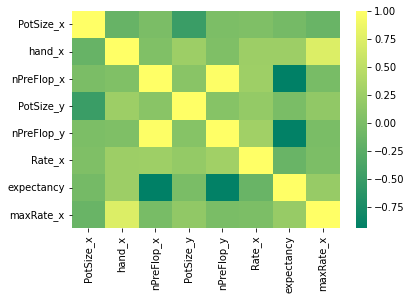

In [5]:
sns.heatmap(preflop2x.corr(), cmap='summer'); # сильная корреляция между блайндами

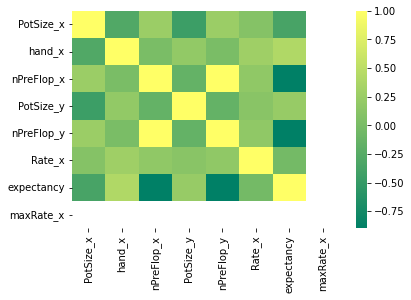

In [6]:
sns.heatmap(preflop2y.corr(), cmap='summer'); # сильная корреляция между блайндами, maxRate_x везде 0

In [119]:
preflop2 = pd.DataFrame(StandardScaler().fit_transform(preflop2), columns=preflop2.columns)
preflop2.head()

,PotSize_x,hand_x,nPreFlop_x,PotSize_y,nPreFlop_y,expectancy,maxRate_x
0,-0.132125,-0.106435,-0.785214,-0.942007,-0.502503,0.771425,-0.110516
1,-0.105720,-0.199091,-0.785214,-0.968262,-0.502503,0.747402,-0.110516
2,-0.954630,0.078877,-0.785214,-0.124159,-0.502503,0.819470,-0.110516
3,-0.356564,-0.755029,-0.785214,-0.718838,-0.502503,0.603266,-0.110516
4,-0.330160,0.542159,-0.785214,-0.745093,-0.502503,0.939584,-0.110516


In [120]:
preflop2_pca = pd.DataFrame(PCA(n_components = 3).fit_transform(preflop2), columns=['6', '4', '2'])
preflop2_pca['4-2'] = preflop2_pca['4'] - preflop2_pca['2']
preflop2_pca = preflop2_pca.drop(['4', '2'], axis=1)

Text(0, 0.5, 'nPreFlop_y - nPreFlop_x')

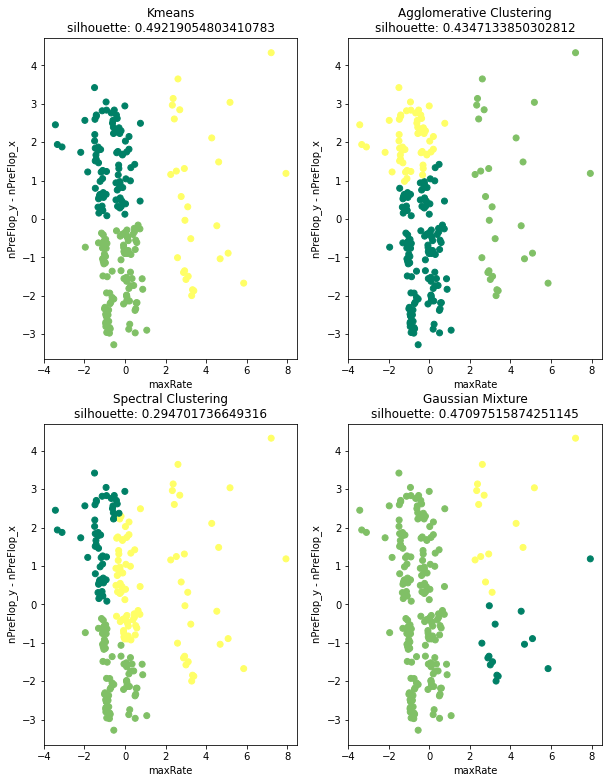

In [127]:
fig, axs = plt.subplots(2, 2, figsize=(10, 13))

pred_km = KMeans(n_clusters=3).fit_predict(preflop2_pca)
axs[0,0].scatter(preflop2_pca['6'], preflop2_pca['4-2'], c=pred_km, cmap ='summer')
axs[0,0].set_title(f'Kmeans\nsilhouette: {silhouette_score(preflop2_pca, pred_km)}')
axs[0,0].set_xlabel('maxRate')
axs[0,0].set_ylabel('nPreFlop_y - nPreFlop_x')

pred_agg = AgglomerativeClustering(n_clusters=3).fit_predict(preflop2_pca)
axs[0,1].scatter(preflop2_pca['6'], preflop2_pca['4-2'], c=pred_agg, cmap ='summer')
axs[0,1].set_title(f'Agglomerative Clustering\nsilhouette: {silhouette_score(preflop2_pca, pred_agg)}')
axs[0,1].set_xlabel('maxRate')
axs[0,1].set_ylabel('nPreFlop_y - nPreFlop_x')

pred_sp = SpectralClustering(n_clusters=3, affinity='nearest_neighbors').fit_predict(preflop2_pca)
axs[1,0].scatter(preflop2_pca['6'], preflop2_pca['4-2'], c=pred_sp, cmap ='summer')
axs[1,0].set_title(f'Spectral Clustering\nsilhouette: {silhouette_score(preflop2_pca, pred_sp)}')
axs[1,0].set_xlabel('maxRate')
axs[1,0].set_ylabel('nPreFlop_y - nPreFlop_x')

pred_gm = GaussianMixture(n_components=3).fit_predict(preflop2_pca)
axs[1,1].scatter(preflop2_pca['6'], preflop2_pca['4-2'], c=pred_gm, cmap ='summer')
axs[1,1].set_title(f'Gaussian Mixture\nsilhouette: {silhouette_score(preflop2_pca, pred_gm)}')
axs[1,1].set_xlabel('maxRate')
axs[1,1].set_ylabel('nPreFlop_y - nPreFlop_x')

In [128]:
print(np.unique(pred_km, return_counts=True))
pred_km = np.where(pred_km == 0, 'f', pred_km)
pred_km = np.where(pred_km == '1', 'k/c', pred_km)
pred_km = np.where(pred_km == '2', 'r/A', pred_km)
np.unique(pred_km, return_counts=True)

(array([0, 1, 2]), array([ 92, 100,  29], dtype=int64))


(array(['f', 'k/c', 'r/A'], dtype='<U11'), array([ 92, 100,  29], dtype=int64))

In [130]:
res_preflop2 = preflop2[['hand_x', 'expectancy', 'nPreFlop_y', 'nPreFlop_x', 'maxRate_x']]
res_preflop2['pred_km'] = pred_km
res_preflop2['nextRate'] = res_preflop2.apply(lambda row: 0 if row['pred_km'] == 'f' else
                                              row['nPreFlop_y'] - row['nPreFlop_x'] if row['pred_km'] == 'k/c' else
                                              row['maxRate_x'], axis=1) # окончательный результат
res_preflop2

,hand_x,expectancy,nPreFlop_y,nPreFlop_x,maxRate_x,pred_km,nextRate
0,0.139543,-2.906860,10,5,0.0,k/c,5.0
1,0.132198,-3.017025,10,5,0.0,k/c,5.0
2,0.154231,-2.686529,10,5,0.0,f,0.0
3,0.088132,-3.678017,10,5,0.0,k/c,5.0
4,0.190953,-2.135703,10,5,0.0,k/c,5.0
...,...,...,...,...,...,...,...
216,0.161576,-20.305456,30,30,0.0,r/A,0.0
217,0.146887,-7.062259,10,10,0.0,k/c,0.0
218,0.095477,-8.090469,10,10,0.0,f,0.0
219,0.044066,-9.118678,10,10,0.0,f,0.0


#### Flop

In [26]:
poker2['nFlop_x'].unique()

array(['[20]', '[0]', '[0, 10]', '[10, 10]', '[10]', '[20, 20, 10]',
       '[20, 10]', '[10, 20]', '[0, 20]', '[0, 30]'], dtype=object)

In [113]:
flop2 = poker2[['PotSize_x', 'EHS_x', 'TablePosition_x', 'nFlop_x', 'PotSize_y', 'EHS_y', 'nFlop_y', 'Rate1']]
for index, row in flop2.iterrows():
    if row['TablePosition_x'] == 2:
        flop2.at[index, 'PotSize_x'] = poker2.iloc[index]['PotSize_y']
        flop2.at[index, 'PotSize_y'] = poker2.iloc[index]['PotSize_x']
        flop2.at[index, 'EHS_x'] = poker2.iloc[index]['EHS_y']
        flop2.at[index, 'EHS_y'] = poker2.iloc[index]['EHS_x']
        flop2.at[index, 'nFlop_x'] = poker2.iloc[index]['nFlop_y']
        flop2.at[index, 'nFlop_y'] = poker2.iloc[index]['nFlop_x']
flop2 = flop2.drop(columns=['TablePosition_x'])
flop2['nFlop_x'] = flop2['nFlop_x'].apply(eval)
flop2['nFlop_y'] = flop2['nFlop_y'].apply(eval)

df = {'PotSize_x': [], 'EHS_x': [], 'nFlop_x': [], 'PotSize_y': [], 'nFlop_y': [], 'Rate_x': [], 'Rate1': []}
for index, row in flop2.iterrows():
    for i in range(len(row['nFlop_x'])):
        df['PotSize_x'].append(row['PotSize_x'])
        df['EHS_x'].append(row['EHS_x'])
        df['nFlop_x'].append(sum(row['nFlop_x'][:i]))
        df['Rate_x'].append(row['nFlop_x'][i])
        df['PotSize_y'].append(row['PotSize_y'])
        df['nFlop_y'].append(sum(row['nFlop_y'][:i]))
        df['Rate1'].append(int(row['Rate1'].split('/')[-1])//int(row['Rate1'].split('/')[0]))
flop2x = pd.DataFrame(df)
flop2x = expectancy(['EHS_x', 'nFlop_x', 'nFlop_y', 'PotSize_x', 'Rate1'], flop2x)
flop2x = flop2x.drop(columns=['Rate1'])
print('flop2x:', flop2x.shape)

flop2['nFlop_y'] = flop2['nFlop_y'].apply(lambda x: [0] + x)
df = {'PotSize_x': [], 'EHS_x': [], 'nFlop_x': [], 'PotSize_y': [], 'nFlop_y': [], 'Rate_x': [], 'Rate1': []}
for index, row in flop2.iterrows():
    for i in range(1, len(row['nFlop_y'])):
        df['PotSize_x'].append(row['PotSize_y'])
        df['EHS_x'].append(row['EHS_y'])
        df['nFlop_x'].append(sum(row['nFlop_y'][:i]))
        df['Rate_x'].append(row['nFlop_y'][i])
        df['PotSize_y'].append(row['PotSize_x'])
        df['nFlop_y'].append(sum(row['nFlop_y'][:i]))
        df['Rate1'].append(int(row['Rate1'].split('/')[-1])//int(row['Rate1'].split('/')[0]))
flop2y = pd.DataFrame(df)
flop2y = expectancy(['EHS_x', 'nFlop_x', 'nFlop_y', 'PotSize_x', 'Rate1'], flop2y)
flop2y = flop2y.drop(columns=['Rate1'])
print('flop2y:', flop2y.shape)

flop2 = pd.concat([flop2x.drop(columns=['Rate_x']), flop2y.drop(columns=['Rate_x'])], ignore_index=True)
flop2.head()

flop2x: (121, 8)
flop2y: (98, 8)


,PotSize_x,EHS_x,nFlop_x,PotSize_y,nFlop_y,expectancy,maxRate_x
0,1318,0.534075,0,625,0,0.000000,0.0
1,1318,0.534075,10,625,20,1.363011,10.0
2,1338,0.739024,0,605,0,0.000000,0.0
3,695,0.877120,0,1248,0,0.000000,0.0
4,695,0.877120,0,1248,10,0.169612,70.0


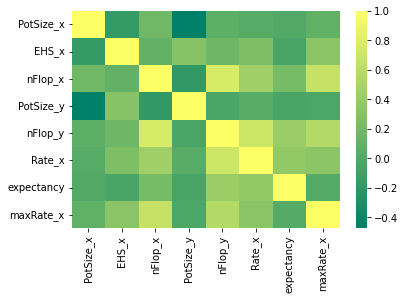

In [23]:
sns.heatmap(flop2x.corr(), cmap='summer');

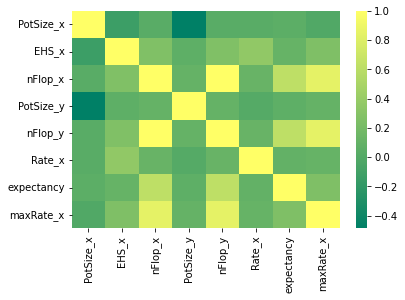

In [24]:
sns.heatmap(flop2y.corr(), cmap='summer');

In [90]:
flop2 = pd.DataFrame(StandardScaler().fit_transform(flop2), columns=flop2.columns)
flop2.head()

,PotSize_x,EHS_x,nFlop_x,PotSize_y,nFlop_y,expectancy,maxRate_x
0,-0.102011,-0.317879,-0.320782,-0.982602,-0.472910,-0.300164,-0.201078
1,-0.102011,-0.317879,1.577903,-0.982602,2.182660,2.301348,-0.048967
2,-0.076063,0.718938,-0.320782,-1.009061,-0.472910,-0.300164,-0.201078
3,-0.910312,1.417552,-0.320782,-0.158409,-0.472910,-0.300164,-0.201078
4,-0.910312,1.417552,-0.320782,-0.158409,0.854875,0.023566,0.863699


In [91]:
flop2_pca = pd.DataFrame(PCA(n_components = 3).fit_transform(flop2), columns=['6', '4', '2'])
flop2_pca['4-2'] = flop2_pca['4'] - flop2_pca['2']
flop2_pca = flop2_pca.drop(['4', '2'], axis=1)

Text(0, 0.5, 'nFlop_y - nFlop_x')

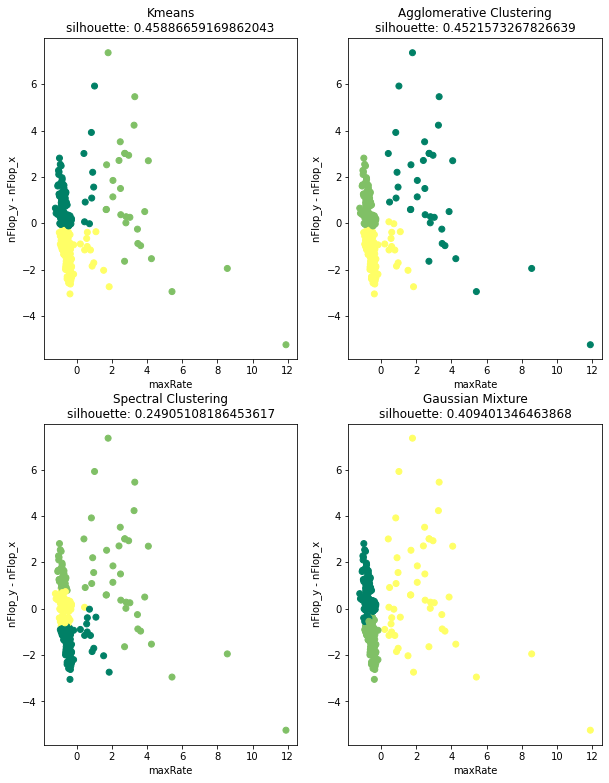

In [111]:
fig, axs = plt.subplots(2, 2, figsize=(10, 13))

pred_km = KMeans(n_clusters=3).fit_predict(flop2_pca)
axs[0,0].scatter(flop2_pca['6'], flop2_pca['4-2'], c=pred_km, cmap ='summer')
axs[0,0].set_title(f'Kmeans\nsilhouette: {silhouette_score(flop2_pca, pred_km)}')
axs[0,0].set_xlabel('maxRate')
axs[0,0].set_ylabel('nFlop_y - nFlop_x')

pred_agg = AgglomerativeClustering(n_clusters=3).fit_predict(flop2_pca)
axs[0,1].scatter(flop2_pca['6'], flop2_pca['4-2'], c=pred_agg, cmap ='summer')
axs[0,1].set_title(f'Agglomerative Clustering\nsilhouette: {silhouette_score(flop2_pca, pred_agg)}')
axs[0,1].set_xlabel('maxRate')
axs[0,1].set_ylabel('nFlop_y - nFlop_x')

pred_sp = SpectralClustering(n_clusters=3, affinity='nearest_neighbors').fit_predict(flop2_pca)
axs[1,0].scatter(flop2_pca['6'], flop2_pca['4-2'], c=pred_sp, cmap ='summer')
axs[1,0].set_title(f'Spectral Clustering\nsilhouette: {silhouette_score(flop2_pca, pred_sp)}')
axs[1,0].set_xlabel('maxRate')
axs[1,0].set_ylabel('nFlop_y - nFlop_x')

pred_gm = GaussianMixture(n_components=3).fit_predict(flop2_pca)
axs[1,1].scatter(flop2_pca['6'], flop2_pca['4-2'], c=pred_gm, cmap ='summer')
axs[1,1].set_title(f'Gaussian Mixture\nsilhouette: {silhouette_score(flop2_pca, pred_gm)}')
axs[1,1].set_xlabel('maxRate')
axs[1,1].set_ylabel('nFlop_y - nFlop_x')

In [112]:
print(np.unique(pred_gm, return_counts=True))
pred_gm = np.where(pred_gm == 0, 'f', pred_gm)
pred_gm = np.where(pred_gm == '1', 'k/c', pred_gm)
pred_gm = np.where(pred_gm == '2', 'b/r/A', pred_gm)
np.unique(pred_gm, return_counts=True)

(array([0, 1, 2], dtype=int64), array([95, 76, 48], dtype=int64))


(array(['b/r/A', 'f', 'k/c'], dtype='<U21'), array([48, 95, 76], dtype=int64))

In [114]:
res_flop2 = flop2[['EHS_x', 'expectancy', 'nFlop_y', 'nFlop_x', 'maxRate_x']]
res_flop2['pred_gm'] = pred_gm
res_flop2['nextRate'] = res_flop2.apply(lambda row: 0 if row['pred_gm'] == 'f' else
                                              row['nFlop_y'] - row['nFlop_x'] if row['pred_gm'] == 'k/c' else
                                              row['maxRate_x'], axis=1) # окончательный результат
res_flop2['pred_gm'] = res_flop2.apply(lambda row: 'b' if (row['pred_gm'] == 'b/r/A' and row['nFlop_y']==0) else
                                              'r/A' if (row['pred_gm'] == 'b/r/A' and row['nFlop_y']!=0) else
                                              row['pred_gm'], axis=1)
res_flop2

,EHS_x,expectancy,nFlop_y,nFlop_x,maxRate_x,pred_gm,nextRate
0,0.534075,0.000000,0,0,0.0,f,0.0
1,0.534075,1.363011,20,10,10.0,r/A,10.0
2,0.739024,0.000000,0,0,0.0,k/c,0.0
3,0.877120,0.000000,0,0,0.0,k/c,0.0
4,0.877120,0.169612,10,0,70.0,r/A,70.0
...,...,...,...,...,...,...,...
214,0.789913,0.041766,20,20,55.0,r/A,55.0
215,0.351005,0.000000,0,0,0.0,f,0.0
216,0.287875,0.000000,0,0,0.0,f,0.0
217,0.507967,0.000000,0,0,0.0,k/c,0.0


#### Turn

In [98]:
poker2['nTurn_x'].unique()

array(['[30, 30]', '[40]', '[0, 40]', '[0]', '[20]', '[0, 20]',
       '[10, 50]', '[15, 35, 50]', '[0, 25, 35]', '[20, 20]', '[10, 30]'],
      dtype=object)

In [137]:
turn2 = poker2[['PotSize_x', 'EHS4_x', 'TablePosition_x', 'nTurn_x', 'PotSize_y', 'EHS4_y', 'nTurn_y', 'Rate2']]
for index, row in turn2.iterrows():
    if row['TablePosition_x'] == 2:
        turn2.at[index, 'PotSize_x'] = poker2.iloc[index]['PotSize_y']
        turn2.at[index, 'PotSize_y'] = poker2.iloc[index]['PotSize_x']
        turn2.at[index, 'EHS4_x'] = poker2.iloc[index]['EHS4_y']
        turn2.at[index, 'EHS4_y'] = poker2.iloc[index]['EHS4_x']
        turn2.at[index, 'nTurn_x'] = poker2.iloc[index]['nTurn_y']
        turn2.at[index, 'nTurn_y'] = poker2.iloc[index]['nTurn_x']
turn2 = turn2.drop(columns=['TablePosition_x'])
turn2['nTurn_x'] = turn2['nTurn_x'].apply(eval)
turn2['nTurn_y'] = turn2['nTurn_y'].apply(eval)

df = {'PotSize_x': [], 'EHS4_x': [], 'nTurn_x': [], 'PotSize_y': [], 'nTurn_y': [], 'Rate_x': [], 'Rate2': []}
for index, row in turn2.iterrows():
    for i in range(len(row['nTurn_x'])):
        df['PotSize_x'].append(row['PotSize_x'])
        df['EHS4_x'].append(row['EHS4_x'])
        df['nTurn_x'].append(sum(row['nTurn_x'][:i]))
        df['Rate_x'].append(row['nTurn_x'][i])
        df['PotSize_y'].append(row['PotSize_y'])
        df['nTurn_y'].append(sum(row['nTurn_y'][:i]))
        df['Rate2'].append(int(row['Rate2'].split('/')[-1])//int(row['Rate2'].split('/')[0]))
turn2x = pd.DataFrame(df)
turn2x = expectancy(['EHS4_x', 'nTurn_x', 'nTurn_y', 'PotSize_x', 'Rate2'], turn2x)
turn2x = turn2x.drop(columns=['Rate2'])
print('turn2x:', turn2x.shape)

turn2['nTurn_y'] = turn2['nTurn_y'].apply(lambda x: [0] + x)
df = {'PotSize_x': [], 'EHS4_x': [], 'nTurn_x': [], 'PotSize_y': [], 'nTurn_y': [], 'Rate_x': [], 'Rate2': []}
for index, row in turn2.iterrows():
    for i in range(1, len(row['nTurn_y'])):
        df['PotSize_x'].append(row['PotSize_y'])
        df['EHS4_x'].append(row['EHS4_y'])
        df['nTurn_x'].append(sum(row['nTurn_y'][:i]))
        df['Rate_x'].append(row['nTurn_y'][i])
        df['PotSize_y'].append(row['PotSize_x'])
        df['nTurn_y'].append(sum(row['nTurn_y'][:i]))
        df['Rate2'].append(int(row['Rate2'].split('/')[-1])//int(row['Rate2'].split('/')[0]))
turn2y = pd.DataFrame(df)
turn2y = expectancy(['EHS4_x', 'nTurn_x', 'nTurn_y', 'PotSize_x', 'Rate2'], turn2y)
turn2y = turn2y.drop(columns=['Rate2'])
print('turn2y:', turn2y.shape)

turn2 = pd.concat([turn2x.drop(columns=['Rate_x']), turn2y.drop(columns=['Rate_x'])], ignore_index=True)
turn2.head()

turn2x: (132, 8)
turn2y: (95, 8)


,PotSize_x,EHS4_x,nTurn_x,PotSize_y,nTurn_y,expectancy,maxRate_x
0,1318,0.566406,0,625,0,0.000000,0.0
1,1318,0.566406,20,625,30,1.816387,15.0
2,1338,0.791051,0,605,0,0.000000,0.0
3,1338,0.791051,20,605,40,0.299719,130.0
4,695,0.907649,0,1248,0,0.000000,0.0


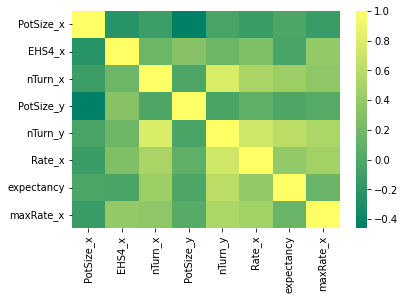

In [46]:
sns.heatmap(turn2x.corr(), cmap='summer');

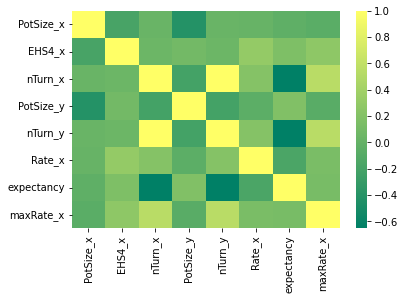

In [47]:
sns.heatmap(turn2y.corr(), cmap='summer');

In [132]:
turn2 = pd.DataFrame(StandardScaler().fit_transform(turn2), columns=turn2.columns)
turn2.head()

,PotSize_x,EHS4_x,nTurn_x,PotSize_y,nTurn_y,expectancy,maxRate_x
0,-0.092600,-0.175265,-0.322748,-0.923316,-0.525833,-0.121056,-0.291073
1,-0.092600,-0.175265,2.040601,-0.923316,1.657656,1.358139,-0.111850
2,-0.065954,0.835101,-0.322748,-0.950331,-0.525833,-0.121056,-0.291073
3,-0.065954,0.835101,2.040601,-0.950331,2.385485,0.123024,1.262195
4,-0.922647,1.359513,-0.322748,-0.081784,-0.525833,-0.121056,-0.291073


In [133]:
turn2_pca = pd.DataFrame(PCA(n_components = 3).fit_transform(turn2), columns=['6', '4', '2'])
turn2_pca['4-2'] = turn2_pca['4'] - turn2_pca['2']
turn2_pca = turn2_pca.drop(['4', '2'], axis=1)

Text(0, 0.5, 'nTurn_y - nTurn_x')

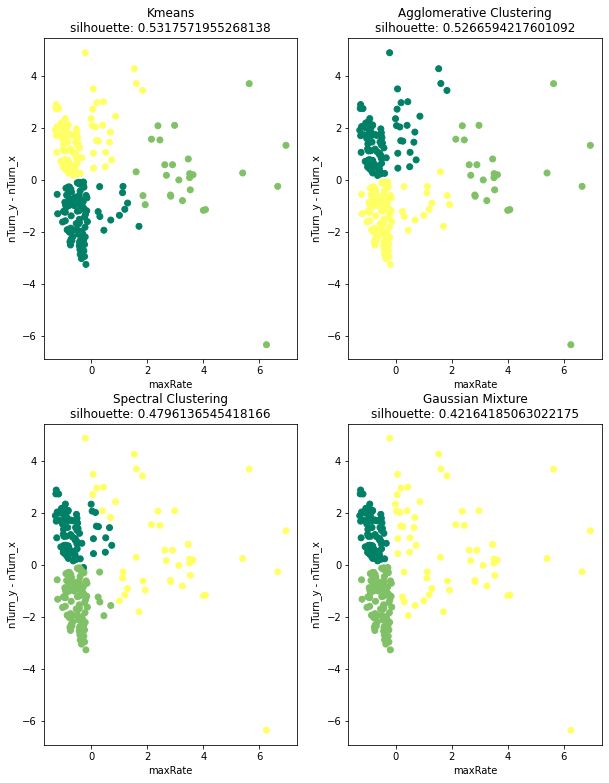

In [135]:
fig, axs = plt.subplots(2, 2, figsize=(10, 13))

pred_km = KMeans(n_clusters=3).fit_predict(turn2_pca)
axs[0,0].scatter(turn2_pca['6'], turn2_pca['4-2'], c=pred_km, cmap ='summer')
axs[0,0].set_title(f'Kmeans\nsilhouette: {silhouette_score(turn2_pca, pred_km)}')
axs[0,0].set_xlabel('maxRate')
axs[0,0].set_ylabel('nTurn_y - nTurn_x')

pred_agg = AgglomerativeClustering(n_clusters=3).fit_predict(turn2_pca)
axs[0,1].scatter(turn2_pca['6'], turn2_pca['4-2'], c=pred_agg, cmap ='summer')
axs[0,1].set_title(f'Agglomerative Clustering\nsilhouette: {silhouette_score(turn2_pca, pred_agg)}')
axs[0,1].set_xlabel('maxRate')
axs[0,1].set_ylabel('nTurn_y - nTurn_x')

pred_sp = SpectralClustering(n_clusters=3, affinity='nearest_neighbors').fit_predict(turn2_pca)
axs[1,0].scatter(turn2_pca['6'], turn2_pca['4-2'], c=pred_sp, cmap ='summer')
axs[1,0].set_title(f'Spectral Clustering\nsilhouette: {silhouette_score(turn2_pca, pred_sp)}')
axs[1,0].set_xlabel('maxRate')
axs[1,0].set_ylabel('nTurn_y - nTurn_x')

pred_gm = GaussianMixture(n_components=3).fit_predict(turn2_pca)
axs[1,1].scatter(turn2_pca['6'], turn2_pca['4-2'], c=pred_gm, cmap ='summer')
axs[1,1].set_title(f'Gaussian Mixture\nsilhouette: {silhouette_score(turn2_pca, pred_gm)}')
axs[1,1].set_xlabel('maxRate')
axs[1,1].set_ylabel('nTurn_y - nTurn_x')

In [136]:
print(np.unique(pred_gm, return_counts=True))
pred_gm = np.where(pred_gm == 0, 'f', pred_gm)
pred_gm = np.where(pred_gm == '1', 'k/c', pred_gm)
pred_gm = np.where(pred_gm == '2', 'b/r/A', pred_gm)
np.unique(pred_gm, return_counts=True)

(array([0, 1, 2], dtype=int64), array([74, 94, 59], dtype=int64))


(array(['b/r/A', 'f', 'k/c'], dtype='<U21'), array([59, 74, 94], dtype=int64))

In [138]:
res_turn2 = turn2[['EHS4_x', 'expectancy', 'nTurn_y', 'nTurn_x', 'maxRate_x']]
res_turn2['pred_gm'] = pred_gm
res_turn2['nextRate'] = res_turn2.apply(lambda row: 0 if row['pred_gm'] == 'f' else
                                              row['nTurn_y'] - row['nTurn_x'] if row['pred_gm'] == 'k/c' else
                                              row['maxRate_x'], axis=1) # окончательный результат
res_turn2['pred_gm'] = res_turn2.apply(lambda row: 'b' if (row['pred_gm'] == 'b/r/A' and row['nTurn_y']==0) else
                                              'r/A' if (row['pred_gm'] == 'b/r/A' and row['nTurn_y']!=0) else
                                              row['pred_gm'], axis=1)
res_turn2

,EHS4_x,expectancy,nTurn_y,nTurn_x,maxRate_x,pred_gm,nextRate
0,0.566406,0.000000,0,0,0.0,f,0.0
1,0.566406,1.816387,30,20,15.0,r/A,15.0
2,0.791051,0.000000,0,0,0.0,f,0.0
3,0.791051,0.299719,40,20,130.0,r/A,130.0
4,0.907649,0.000000,0,0,0.0,k/c,0.0
...,...,...,...,...,...,...,...
222,0.827195,0.623131,30,30,110.0,r/A,110.0
223,0.329343,0.000000,0,0,0.0,f,0.0
224,0.289507,0.000000,0,0,0.0,k/c,0.0
225,0.548197,0.000000,0,0,0.0,k/c,0.0


#### River

In [148]:
poker2['nRiver_x'].unique()

array(['[20]', '[40]', '[15, 25]', '[0]', '[0, 20]', '[0, 40, 20]',
       '[0, 40]', '[30, 30]', '[20, 20]', '[14]'], dtype=object)

In [146]:
river2 = poker2[['PotSize_x', 'EHS5_x', 'TablePosition_x', 'nRiver_x', 'PotSize_y', 'EHS5_y', 'nRiver_y', 'Rate3']]
for index, row in river2.iterrows():
    if row['TablePosition_x'] == 2:
        river2.at[index, 'PotSize_x'] = poker2.iloc[index]['PotSize_y']
        river2.at[index, 'PotSize_y'] = poker2.iloc[index]['PotSize_x']
        river2.at[index, 'EHS5_x'] = poker2.iloc[index]['EHS5_y']
        river2.at[index, 'EHS5_y'] = poker2.iloc[index]['EHS5_x']
        river2.at[index, 'nRiver_x'] = poker2.iloc[index]['nRiver_y']
        river2.at[index, 'nRiver_y'] = poker2.iloc[index]['nRiver_x']
river2 = river2.drop(columns=['TablePosition_x'])
river2['nRiver_x'] = river2['nRiver_x'].apply(eval)
river2['nRiver_y'] = river2['nRiver_y'].apply(eval)

df = {'PotSize_x': [], 'EHS5_x': [], 'nRiver_x': [], 'PotSize_y': [], 'nRiver_y': [], 'Rate_x': [], 'Rate3': []}
for index, row in river2.iterrows():
    for i in range(len(row['nRiver_x'])):
        df['PotSize_x'].append(row['PotSize_x'])
        df['EHS5_x'].append(row['EHS5_x'])
        df['nRiver_x'].append(sum(row['nRiver_x'][:i]))
        df['Rate_x'].append(row['nRiver_x'][i])
        df['PotSize_y'].append(row['PotSize_y'])
        df['nRiver_y'].append(sum(row['nRiver_y'][:i]))
        df['Rate3'].append(int(row['Rate3'].split('/')[-1])//int(row['Rate3'].split('/')[0]))
river2x = pd.DataFrame(df)
river2x = expectancy(['EHS5_x', 'nRiver_x', 'nRiver_y', 'PotSize_x', 'Rate3'], river2x)
river2x = river2x.drop(columns=['Rate3'])
print('river2x:', river2x.shape)

river2['nRiver_y'] = river2['nRiver_y'].apply(lambda x: [0] + x)
df = {'PotSize_x': [], 'EHS5_x': [], 'nRiver_x': [], 'PotSize_y': [], 'nRiver_y': [], 'Rate_x': [], 'Rate3': []}
for index, row in river2.iterrows():
    for i in range(1, len(row['nRiver_y'])):
        df['PotSize_x'].append(row['PotSize_y'])
        df['EHS5_x'].append(row['EHS5_y'])
        df['nRiver_x'].append(sum(row['nRiver_y'][:i]))
        df['Rate_x'].append(row['nRiver_y'][i])
        df['PotSize_y'].append(row['PotSize_x'])
        df['nRiver_y'].append(sum(row['nRiver_y'][:i]))
        df['Rate3'].append(int(row['Rate3'].split('/')[-1])//int(row['Rate3'].split('/')[0]))
river2y = pd.DataFrame(df)
river2y = expectancy(['EHS5_x', 'nRiver_x', 'nRiver_y', 'PotSize_x', 'Rate3'], river2y)
river2y = river2y.drop(columns=['Rate3'])
print('river2y:', river2y.shape)

river2 = pd.concat([river2x.drop(columns=['Rate_x']), river2y.drop(columns=['Rate_x'])], ignore_index=True)
river2.head()

river2x: (116, 8)
river2y: (90, 8)


,PotSize_x,EHS5_x,nRiver_x,PotSize_y,nRiver_y,expectancy,maxRate_x
0,1318,0.552525,0,625,0,0.000000,0.0
1,1338,0.857576,0,605,0,0.000000,0.0
2,1338,0.857576,10,605,40,0.121212,230.0
3,695,0.953535,0,1248,0,0.000000,0.0
4,695,0.953535,15,1248,40,8.636364,620.0


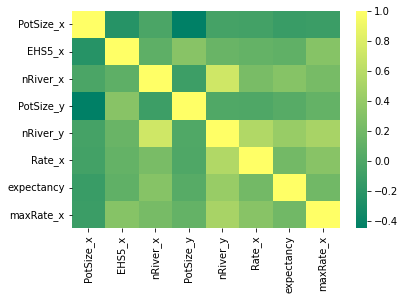

In [70]:
sns.heatmap(river2x.corr(), cmap='summer');

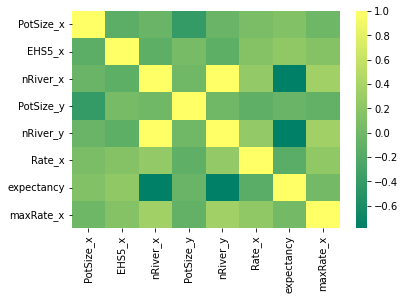

In [72]:
sns.heatmap(river2y.corr(), cmap='summer');

In [140]:
river2 = pd.DataFrame(StandardScaler().fit_transform(river2), columns=river2.columns)
river2.head()

,PotSize_x,EHS5_x,nRiver_x,PotSize_y,nRiver_y,expectancy,maxRate_x
0,-0.063569,-0.237354,-0.245618,-1.004566,-0.431265,-0.044236,-0.221601
1,-0.037311,0.874607,-0.245618,-1.031520,-0.431265,-0.044236,-0.221601
2,-0.037311,0.874607,1.469545,-1.031520,3.431367,0.006331,1.314529
3,-0.881533,1.224397,-0.245618,-0.164933,-0.431265,-0.044236,-0.221601
4,-0.881533,1.224397,2.327127,-0.164933,3.431367,3.558662,3.919270


In [141]:
river2_pca = pd.DataFrame(PCA(n_components = 3).fit_transform(river2), columns=['6', '4', '2'])
river2_pca['4-2'] = river2_pca['4'] - river2_pca['2']
river2_pca = river2_pca.drop(['4', '2'], axis=1)

Text(0, 0.5, 'nRiver_y')

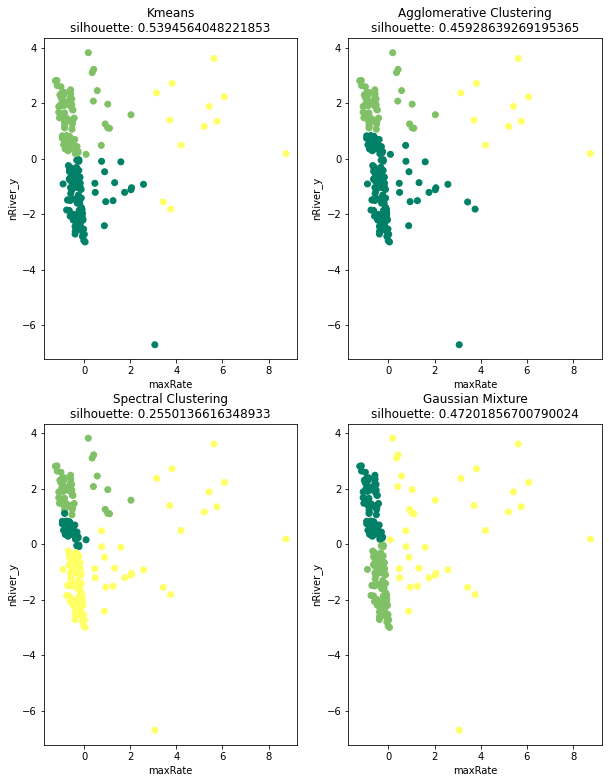

In [144]:
fig, axs = plt.subplots(2, 2, figsize=(10, 13))

pred_km = KMeans(n_clusters=3).fit_predict(river2_pca)
axs[0,0].scatter(river2_pca['6'], river2_pca['4-2'], c=pred_km, cmap ='summer')
axs[0,0].set_title(f'Kmeans\nsilhouette: {silhouette_score(river2_pca, pred_km)}')
axs[0,0].set_xlabel('maxRate')
axs[0,0].set_ylabel('nRiver_y')

pred_agg = AgglomerativeClustering(n_clusters=3).fit_predict(river2_pca)
axs[0,1].scatter(river2_pca['6'], river2_pca['4-2'], c=pred_agg, cmap ='summer')
axs[0,1].set_title(f'Agglomerative Clustering\nsilhouette: {silhouette_score(river2_pca, pred_agg)}')
axs[0,1].set_xlabel('maxRate')
axs[0,1].set_ylabel('nRiver_y')

pred_sp = SpectralClustering(n_clusters=3, affinity='nearest_neighbors').fit_predict(river2_pca)
axs[1,0].scatter(river2_pca['6'], river2_pca['4-2'], c=pred_sp, cmap ='summer')
axs[1,0].set_title(f'Spectral Clustering\nsilhouette: {silhouette_score(river2_pca, pred_sp)}')
axs[1,0].set_xlabel('maxRate')
axs[1,0].set_ylabel('nRiver_y')

pred_gm = GaussianMixture(n_components=3).fit_predict(river2_pca)
axs[1,1].scatter(river2_pca['6'], river2_pca['4-2'], c=pred_gm, cmap ='summer')
axs[1,1].set_title(f'Gaussian Mixture\nsilhouette: {silhouette_score(river2_pca, pred_gm)}')
axs[1,1].set_xlabel('maxRate')
axs[1,1].set_ylabel('nRiver_y')

In [145]:
print(np.unique(pred_gm, return_counts=True))
pred_gm = np.where(pred_gm == 0, 'f', pred_gm)
pred_gm = np.where(pred_gm == '1', 'k/c', pred_gm)
pred_gm = np.where(pred_gm == '2', 'b/r/A', pred_gm)
np.unique(pred_gm, return_counts=True)

(array([0, 1, 2], dtype=int64), array([81, 87, 38], dtype=int64))


(array(['b/r/A', 'f', 'k/c'], dtype='<U21'), array([38, 81, 87], dtype=int64))

In [147]:
res_river2 = river2[['EHS5_x', 'expectancy', 'nRiver_y', 'nRiver_x', 'maxRate_x']]
res_river2['pred_gm'] = pred_gm
res_river2['nextRate'] = res_river2.apply(lambda row: 0 if row['pred_gm'] == 'f' else
                                              row['nRiver_y'] - row['nRiver_x'] if row['pred_gm'] == 'k/c' else
                                              row['maxRate_x'], axis=1) # окончательный результат
res_river2['pred_gm'] = res_river2.apply(lambda row: 'b' if (row['pred_gm'] == 'b/r/A' and row['nRiver_y']==0) else
                                              'r/A' if (row['pred_gm'] == 'b/r/A' and row['nRiver_y']!=0) else
                                              row['pred_gm'], axis=1)
res_river2

,EHS5_x,expectancy,nRiver_y,nRiver_x,maxRate_x,pred_gm,nextRate
0,0.552525,0.000000,0,0,0.0,f,0.0
1,0.857576,0.000000,0,0,0.0,f,0.0
2,0.857576,0.121212,40,10,230.0,r/A,230.0
3,0.953535,0.000000,0,0,0.0,k/c,0.0
4,0.953535,8.636364,40,15,620.0,r/A,620.0
...,...,...,...,...,...,...,...
201,0.928283,0.000000,0,0,0.0,k/c,0.0
202,0.318182,0.000000,0,0,0.0,f,0.0
203,0.107576,0.000000,0,0,0.0,k/c,0.0
204,0.590404,0.000000,0,0,0.0,k/c,0.0


### Анализ стилей игры

In [23]:
print('player x won:', np.sum(poker2['Won_x']), '\nplayer y won:', np.sum(poker2['Won_y'])) # больше выиграл игрок x, что меньше рисковал

player x won: 7790 
player y won: 3764


#### Pre-flop

In [228]:
res_preflop2x = pd.concat([res_preflop2[:129], preflop2x['Rate_x']], axis=1)
res_preflop2y = res_preflop2[129:]
res_preflop2y = res_preflop2y.reset_index(drop=True)
res_preflop2y = pd.concat([res_preflop2y, preflop2y['Rate_x']], axis=1)

In [229]:
msex = mean_squared_error(res_preflop2x['Rate_x'], res_preflop2x['nextRate'])
r2x = r2_score(res_preflop2x['Rate_x'], res_preflop2x['nextRate'])
print('MSE_x:', msex, '\nR2_x:', r2x)

msey = mean_squared_error(res_preflop2y['Rate_x'], res_preflop2y['nextRate']) # больше отклоняется от рекомендованных ставок
r2y = r2_score(res_preflop2y['Rate_x'], res_preflop2y['nextRate'])
print('MSE_y:', msey, '\nR2_y:', r2y)

MSE_x: 82.36434108527132 
R2_x: -2.667714744447417
MSE_y: 140.2173913043478 
R2_y: -1.5561059659702776


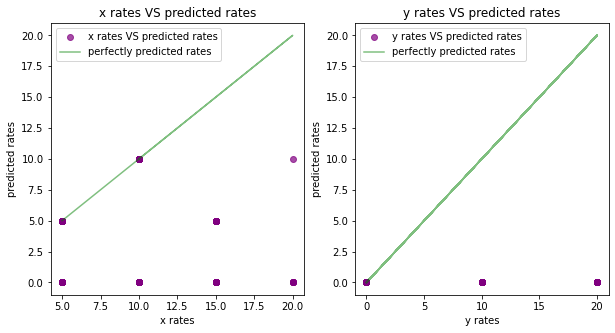

In [230]:
# график истинных значений по сравнению с предсказанными
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].scatter(res_preflop2x['Rate_x'], res_preflop2x['nextRate'], color='purple', alpha=0.7, label='x rates VS predicted rates')
axs[0].plot(res_preflop2x['Rate_x'], res_preflop2x['Rate_x'], color='green', alpha=0.5, label='perfectly predicted rates')
axs[0].set_title('x rates VS predicted rates')
axs[0].set_xlabel('x rates')
axs[0].set_ylabel('predicted rates')
axs[0].legend() # игрок x много рисковал

axs[1].scatter(res_preflop2y['Rate_x'], res_preflop2y['nextRate'], color='purple', alpha=0.7, label='y rates VS predicted rates')
axs[1].plot(res_preflop2y['Rate_x'], res_preflop2y['Rate_x'], color='green', alpha=0.5, label='perfectly predicted rates')
axs[1].set_title('y rates VS predicted rates')
axs[1].set_xlabel('y rates')
axs[1].set_ylabel('predicted rates')
axs[1].legend() # игрок y много рисковал
plt.show()

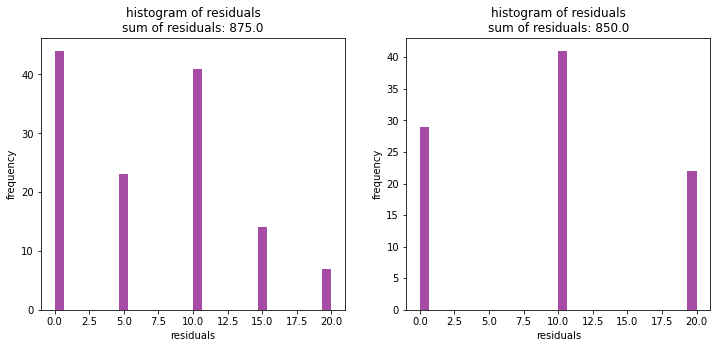

In [231]:
# гистограмма остатков
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

residuals = res_preflop2x['Rate_x'] - res_preflop2x['nextRate']
axs[0].hist(residuals, bins=30, color='purple', alpha=0.7)
axs[0].set_title(f'histogram of residuals\nsum of residuals: {sum(residuals)}')
axs[0].set_xlabel('residuals')
axs[0].set_ylabel('frequency') # игрок x превышал максимальную выигрышную ставку (мат. ожидание >= 0) на небольшие суммы

residuals = res_preflop2y['Rate_x'] - res_preflop2y['nextRate']
axs[1].hist(residuals, bins=30, color='purple', alpha=0.7)
axs[1].set_title(f'histogram of residuals\nsum of residuals: {sum(residuals)}')
axs[1].set_xlabel('residuals')
axs[1].set_ylabel('frequency') # игрок y превышал максимальную выигрышную ставку (мат. ожидание >= 0) на небольшие суммы
plt.show() # игрок x сильнее превышал рекомендованные ставки (блеф или ходы сделаны случайно)

#### Flop

In [307]:
res_flop2x = pd.concat([res_flop2[:121], flop2x['Rate_x']], axis=1)
res_flop2y = res_flop2[121:]
res_flop2y = res_flop2y.reset_index(drop=True)
res_flop2y = pd.concat([res_flop2y, flop2y['Rate_x']], axis=1)

In [233]:
msex = mean_squared_error(res_flop2x['Rate_x'], res_flop2x['nextRate'])
r2x = r2_score(res_flop2x['Rate_x'], res_flop2x['nextRate'])
print('MSE_x:', msex, '\nR2_x:', r2x)

msey = mean_squared_error(res_flop2y['Rate_x'], res_flop2y['nextRate']) # больше отклоняется от рекомендованных ставок
r2y = r2_score(res_flop2y['Rate_x'], res_flop2y['nextRate'])
print('MSE_y:', msey, '\nR2_y:', r2y)

MSE_x: 7051.239669421488 
R2_x: -127.43642697188355
MSE_y: 617.0918367346939 
R2_y: -10.188502926184633


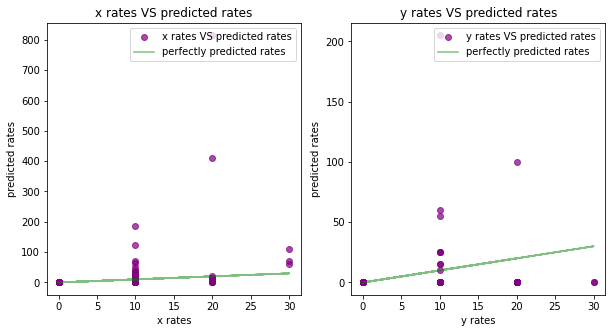

In [234]:
# график истинных значений по сравнению с предсказанными
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].scatter(res_flop2x['Rate_x'], res_flop2x['nextRate'], color='purple', alpha=0.7, label='x rates VS predicted rates')
axs[0].plot(res_flop2x['Rate_x'], res_flop2x['Rate_x'], color='green', alpha=0.5, label='perfectly predicted rates')
axs[0].set_title('x rates VS predicted rates')
axs[0].set_xlabel('x rates')
axs[0].set_ylabel('predicted rates')
axs[0].legend() # игрок x мало рисковал

axs[1].scatter(res_flop2y['Rate_x'], res_flop2y['nextRate'], color='purple', alpha=0.7, label='y rates VS predicted rates')
axs[1].plot(res_flop2y['Rate_x'], res_flop2y['Rate_x'], color='green', alpha=0.5, label='perfectly predicted rates')
axs[1].set_title('y rates VS predicted rates')
axs[1].set_xlabel('y rates')
axs[1].set_ylabel('predicted rates')
axs[1].legend() # игрок y мало рисковал
plt.show()

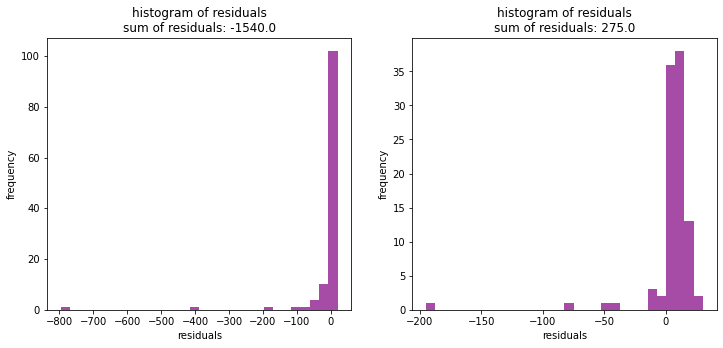

In [309]:
# гистограмма остатков
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

residuals = res_flop2x['Rate_x'] - res_flop2x['nextRate']
axs[0].hist(residuals, bins=30, color='purple', alpha=0.7)
axs[0].set_title(f'histogram of residuals\nsum of residuals: {sum(residuals)}')
axs[0].set_xlabel('residuals')
axs[0].set_ylabel('frequency') # игрок x ставил ниже максимальной выигрышной ставки (мат. ожидание >= 0)

residuals = res_flop2y['Rate_x'] - res_flop2y['nextRate']
axs[1].hist(residuals, bins=30, color='purple', alpha=0.7)
axs[1].set_title(f'histogram of residuals\nsum of residuals: {sum(residuals)}')
axs[1].set_xlabel('residuals')
axs[1].set_ylabel('frequency') # игрок y превышал максимальную выигрышную ставку (мат. ожидание >= 0) на небольшие суммы
plt.show() # игрок y превышал рекомендованные ставки (блеф или ходы сделаны случайно)

#### Turn

In [236]:
res_turn2x = pd.concat([res_turn2[:132], turn2x['Rate_x']], axis=1)
res_turn2y = res_turn2[132:]
res_turn2y = res_turn2y.reset_index(drop=True)
res_turn2y = pd.concat([res_turn2y, turn2y['Rate_x']], axis=1)

In [237]:
msex = mean_squared_error(res_turn2x['Rate_x'], res_turn2x['nextRate'])
r2x = r2_score(res_turn2x['Rate_x'], res_turn2x['nextRate'])
print('MSE_x:', msex, '\nR2_x:', r2x)

msey = mean_squared_error(res_turn2y['Rate_x'], res_turn2y['nextRate']) # больше отклоняется от рекомендованных ставок
r2y = r2_score(res_turn2y['Rate_x'], res_turn2y['nextRate'])
print('MSE_y:', msey, '\nR2_y:', r2y)

MSE_x: 10519.69696969697 
R2_x: -61.06663957740756
MSE_y: 998.421052631579 
R2_y: -5.410607569721116


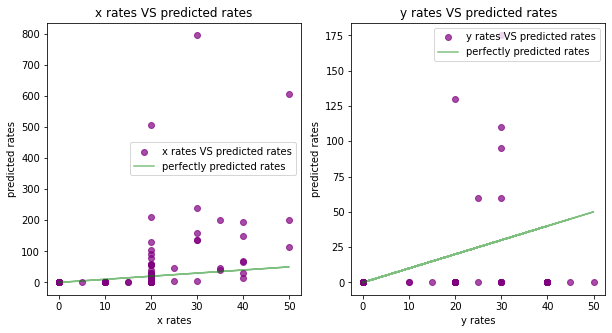

In [238]:
# график истинных значений по сравнению с предсказанными
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].scatter(res_turn2x['Rate_x'], res_turn2x['nextRate'], color='purple', alpha=0.7, label='x rates VS predicted rates')
axs[0].plot(res_turn2x['Rate_x'], res_turn2x['Rate_x'], color='green', alpha=0.5, label='perfectly predicted rates')
axs[0].set_title('x rates VS predicted rates')
axs[0].set_xlabel('x rates')
axs[0].set_ylabel('predicted rates')
axs[0].legend() # игрок x мало рисковал

axs[1].scatter(res_turn2y['Rate_x'], res_turn2y['nextRate'], color='purple', alpha=0.7, label='y rates VS predicted rates')
axs[1].plot(res_turn2y['Rate_x'], res_turn2y['Rate_x'], color='green', alpha=0.5, label='perfectly predicted rates')
axs[1].set_title('y rates VS predicted rates')
axs[1].set_xlabel('y rates')
axs[1].set_ylabel('predicted rates')
axs[1].legend() # игрок y рисковал в меру
plt.show()

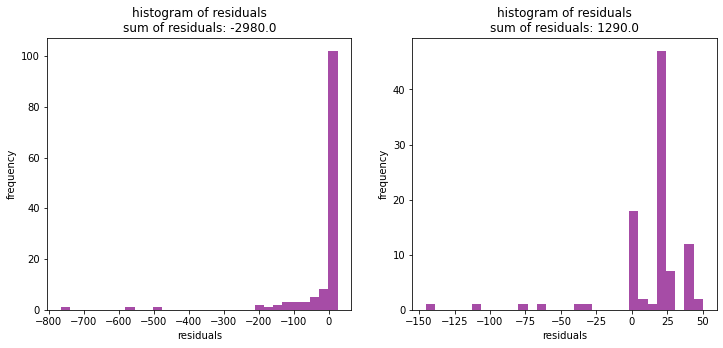

In [239]:
# гистограмма остатков
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

residuals = res_turn2x['Rate_x'] - res_turn2x['nextRate']
axs[0].hist(residuals, bins=30, color='purple', alpha=0.7)
axs[0].set_title(f'histogram of residuals\nsum of residuals: {sum(residuals)}')
axs[0].set_xlabel('residuals')
axs[0].set_ylabel('frequency') # игрок x ставил ниже максимальной выигрышной ставки (мат. ожидание >= 0)

residuals = res_turn2y['Rate_x'] - res_turn2y['nextRate']
axs[1].hist(residuals, bins=30, color='purple', alpha=0.7)
axs[1].set_title(f'histogram of residuals\nsum of residuals: {sum(residuals)}')
axs[1].set_xlabel('residuals')
axs[1].set_ylabel('frequency') # игрок y превышал максимальную выигрышную ставку (мат. ожидание >= 0) на небольшие суммы
plt.show() # игрок y превышал рекомендованные ставки (блеф или ходы сделаны случайно)

#### River

In [240]:
res_river2x = pd.concat([res_river2[:116], river2x['Rate_x']], axis=1)
res_river2y = res_river2[116:]
res_river2y = res_river2y.reset_index(drop=True)
res_river2y = pd.concat([res_river2y, river2y['Rate_x']], axis=1)

In [241]:
msex = mean_squared_error(res_river2x['Rate_x'], res_river2x['nextRate'])
r2x = r2_score(res_river2x['Rate_x'], res_river2x['nextRate'])
print('MSE_x:', msex, '\nR2_x:', r2x)

msey = mean_squared_error(res_river2y['Rate_x'], res_river2y['nextRate']) # больше отклоняется от рекомендованных ставок
r2y = r2_score(res_river2y['Rate_x'], res_river2y['nextRate'])
print('MSE_y:', msey, '\nR2_y:', r2y)

MSE_x: 32464.439655172413 
R2_x: -219.16001411148076
MSE_y: 8563.288888888888 
R2_y: -57.27206710105819


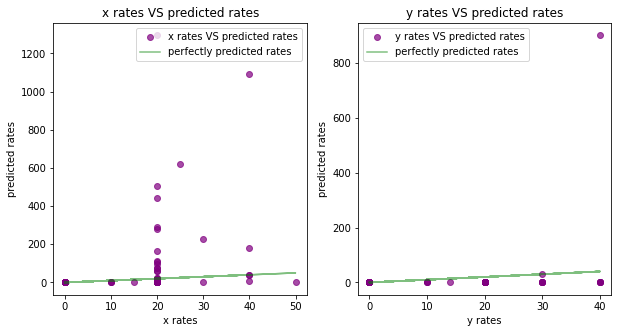

In [242]:
# график истинных значений по сравнению с предсказанными
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].scatter(res_river2x['Rate_x'], res_river2x['nextRate'], color='purple', alpha=0.7, label='x rates VS predicted rates')
axs[0].plot(res_river2x['Rate_x'], res_river2x['Rate_x'], color='green', alpha=0.5, label='perfectly predicted rates')
axs[0].set_title('x rates VS predicted rates')
axs[0].set_xlabel('x rates')
axs[0].set_ylabel('predicted rates')
axs[0].legend() # игрок x много рисковал

axs[1].scatter(res_river2y['Rate_x'], res_river2y['nextRate'], color='purple', alpha=0.7, label='y rates VS predicted rates')
axs[1].plot(res_river2y['Rate_x'], res_river2y['Rate_x'], color='green', alpha=0.5, label='perfectly predicted rates')
axs[1].set_title('y rates VS predicted rates')
axs[1].set_xlabel('y rates')
axs[1].set_ylabel('predicted rates')
axs[1].legend() # игрок y много рисковал
plt.show()

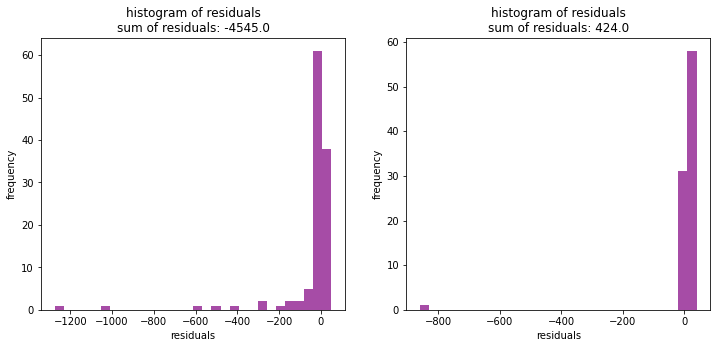

In [243]:
# гистограмма остатков
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

residuals = res_river2x['Rate_x'] - res_river2x['nextRate']
axs[0].hist(residuals, bins=30, color='purple', alpha=0.7)
axs[0].set_title(f'histogram of residuals\nsum of residuals: {sum(residuals)}')
axs[0].set_xlabel('residuals')
axs[0].set_ylabel('frequency') # игрок x ставил ниже максимальной выигрышной ставки (мат. ожидание >= 0)

residuals = res_river2y['Rate_x'] - res_river2y['nextRate']
axs[1].hist(residuals, bins=30, color='purple', alpha=0.7)
axs[1].set_title(f'histogram of residuals\nsum of residuals: {sum(residuals)}')
axs[1].set_xlabel('residuals')
axs[1].set_ylabel('frequency') # игрок y превышал максимальную выигрышную ставку (мат. ожидание >= 0) на небольшие суммы
plt.show() # игрок y превышал рекомендованные ставки (блеф или ходы сделаны случайно)

### Обучение моделей регрессии

In [209]:
res_preflop2 = res_preflop2.rename(columns={'hand_x': 'strength', 'nPreFlop_y': 'n_y', 'nPreFlop_x': 'n_x', 'maxRate_x': 'maxRate'})
res_preflop2.drop(columns=['pred_km'], inplace=True)
res_flop2 = res_flop2.rename(columns={'EHS_x': 'strength', 'nFlop_y': 'n_y', 'nFlop_x': 'n_x', 'maxRate_x': 'maxRate'})
res_flop2.drop(columns=['pred_gm'], inplace=True)
res_turn2 = res_turn2.rename(columns={'EHS4_x': 'strength', 'nTurn_y': 'n_y', 'nTurn_x': 'n_x', 'maxRate_x': 'maxRate'})
res_turn2.drop(columns=['pred_gm'], inplace=True)
res_river2 = res_river2.rename(columns={'EHS5_x': 'strength', 'nRiver_y': 'n_y', 'nRiver_x': 'n_x', 'maxRate_x': 'maxRate'})
res_river2.drop(columns=['pred_gm'], inplace=True)
game2 = pd.concat([res_preflop2, res_flop2, res_turn2, res_river2], ignore_index=True)
game2.to_csv("game2.csv", index=False)
game2.head()

,strength,expectancy,n_y,n_x,maxRate,nextRate
0,0.139543,-2.906860,10,5,0.0,5.0
1,0.132198,-3.017025,10,5,0.0,5.0
2,0.154231,-2.686529,10,5,0.0,0.0
3,0.088132,-3.678017,10,5,0.0,5.0
4,0.190953,-2.135703,10,5,0.0,5.0


In [210]:
X = game2.drop(['nextRate'], axis=1).values
y = game2['nextRate']

In [211]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

In [212]:
reg_tree = DecisionTreeRegressor()
reg_tree.fit(X_train, y_train) # минимизация MSE

mse = mean_squared_error(y_test, reg_tree.predict(X_test))
r2 = r2_score(y_test, reg_tree.predict(X_test))
print('MSE:', mse, '\nR2:', r2)

MSE: 166.1715972330408 
R2: 0.9798627103944193


In [213]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
np.mean(cross_val_score(reg_tree, X_test, y_test, cv=kfold, scoring='r2'))

0.8625597775423179

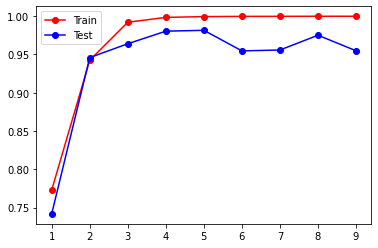

In [331]:
max_depth = list(range(1, 10))
scores_test = []
scores_train = []
for i in max_depth:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)
    reg_tree = DecisionTreeRegressor(max_depth=i)
    reg_tree.fit(X_train,y_train)
    scores_test.append(r2_score(y_test, reg_tree.predict(X_test)))
    scores_train.append(r2_score(y_train, reg_tree.predict(X_train)))
plt.plot(max_depth, scores_train, 'r-o')
plt.plot(max_depth, scores_test, 'b-o')
plt.legend(['Train', 'Test'])

In [311]:
tree_params = {'max_depth': np.arange(4, 7), 'min_samples_split': np.arange(1, 10), 'ccp_alpha': np.arange(0, 0.11, 0.01)}
reg_grid = GridSearchCV(reg_tree, tree_params, cv=5, n_jobs=-1, scoring='r2')

reg_grid.fit(X_train, y_train)
r2_score(y_test, reg_tree.predict(X_test))

0.9798627103944193

In [312]:
print(reg_grid.best_estimator_) #дерево с лучшими гиперпараметрами
reg_grid.best_score_

DecisionTreeRegressor(ccp_alpha=0.05, max_depth=6)


0.9709452861343333

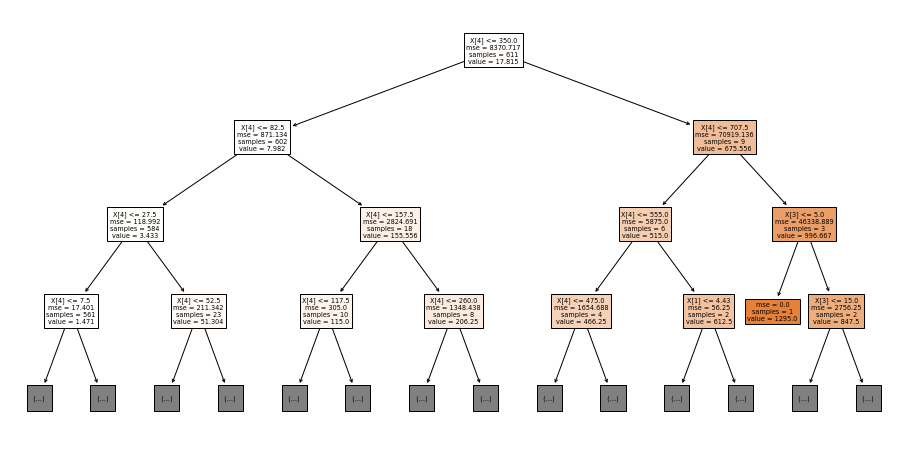

In [321]:
plt.figure(figsize=(16,8))
plot_tree(reg_grid.best_estimator_, max_depth=3, filled=True)
plt.show()

In [367]:
tree_pred = reg_grid.best_estimator_.predict(X)
game2['tree_pred'] = tree_pred//5*5
game2.head()

,strength,expectancy,n_y,n_x,maxRate,nextRate,tree_pred
0,0.139543,-2.906860,10,5,0.0,5.0,0.0
1,0.132198,-3.017025,10,5,0.0,5.0,0.0
2,0.154231,-2.686529,10,5,0.0,0.0,0.0
3,0.088132,-3.678017,10,5,0.0,5.0,0.0
4,0.190953,-2.135703,10,5,0.0,5.0,0.0


### Реализация класса для предсказания оптимальных ставок

In [212]:
class RatePredictor2:
    def __init__(self, X, y, h1_S, h1_C, h2_S, h2_C, S1=None, C1=None, S2=None, C2=None, S3=None, C3=None, S4=None, C4=None, S5=None, C5=None,
                 PotSize_x=1000, n_x=0, n_y=0, Rate=0, risk=0):
        if risk > PotSize_x:
            risk = PotSize_x
        if (S5 is not None) and (C5 is not None):
            self.cols = ['h1_S', 'h1_C', 'h2_S', 'h2_C', 'S1', 'C1', 'S2', 'C2', 'S3', 'C3', 'S4', 'C4', 'S5', 'C5']
            self.data = {'h1_S': h1_S, 'h1_C': h1_C, 'h2_S': h2_S, 'h2_C': h2_C, 'S1': S1, 'C1': C1, 'S2': S2, 'C2': C2, 'S3': S3, 'C3': C3,
                         'S4': S4, 'C4': C4, 'S5': S5, 'C5': C5, 'PotSize_x': PotSize_x, 'n_x': n_x, 'n_y': n_y,
                         'Rate': Rate}
        elif (S4 is not None) and (C4 is not None):
            self.cols = ['h1_S', 'h1_C', 'h2_S', 'h2_C', 'S1', 'C1', 'S2', 'C2', 'S3', 'C3', 'S4', 'C4']
            self.data = {'h1_S': h1_S, 'h1_C': h1_C, 'h2_S': h2_S, 'h2_C': h2_C, 'S1': S1, 'C1': C1, 'S2': S2, 'C2': C2, 'S3': S3, 'C3': C3,
                         'S4': S4, 'C4': C4, 'PotSize_x': PotSize_x, 'n_x': n_x, 'n_y': n_y, 'Rate': Rate}
        elif (S3 is not None) and (C3 is not None):
            self.cols = ['h1_S', 'h1_C', 'h2_S', 'h2_C', 'S1', 'C1', 'S2', 'C2', 'S3', 'C3']
            self.data = {'h1_S': h1_S, 'h1_C': h1_C, 'h2_S': h2_S, 'h2_C': h2_C, 'S1': S1, 'C1': C1, 'S2': S2, 'C2': C2, 'S3': S3, 'C3': C3,
                         'PotSize_x': PotSize_x, 'n_x': n_x, 'n_y': n_y, 'Rate': Rate}
        else:
            self.cols = ['h1_S', 'h1_C', 'h2_S', 'h2_C']
            self.data = {'h1_S': h1_S, 'h1_C': h1_C, 'h2_S': h2_S, 'h2_C': h2_C,
                         'PotSize_x': PotSize_x, 'n_x': n_x, 'n_y': n_y, 'Rate': 0}
        self.df = pd.DataFrame([self.data])
        self.risk = risk
        self.X, self.y = X, y
        
    def comb_proba(self, ftr: int, comb: int) -> dict:
        def C(k: int, n: int) -> int:
            return math.factorial(n)//(math.factorial(k)*math.factorial(n-k))
        
        pocket_pair = 1/17
        one_suit = 4/17
        chaos = 12/17
        pp = os = ch = 0

        if comb == 0: # 'high card':
            hc = (C(ftr-3+5,13)-10*C(ftr-3,8))*(C(1,4)**(ftr+2)-4**(ftr-3+1))/C(ftr+2,52)
            os = ch = hc/(one_suit+chaos)
        elif comb == 1: # 'pair':
            pp = C(ftr-3+3,12)*C(1,4)**(ftr-3+3)/C(ftr,50)
            os = ch = (C(1,3)*C(ftr-3+2,11)*C(1,4)**(ftr-3+2)*2+C(ftr-3+2,11)*C(1,4)*C(1,3)*C(1,4)**(ftr-3+1))/C(ftr,50)
        elif comb == 2: # 'two pair':
            pp = C(ftr-3+2,12)*C(1,4)*C(1,3)*C(1,4)**(ftr-3+1)/C(ftr,50)
            os = ch = (C(1,3)*C(1,3)*C(ftr-3+1,11)*C(1,4)**(ftr-3+1)+C(1,3)*C(1,11)*C(2,4)*2*C(ftr-3,47))/C(ftr,50)
        elif comb == 3: # 'three of a kind':
            pp = C(1,2)*C(ftr-3+2,12)*C(1,4)**(ftr-3+2)/C(ftr,50)
            os = ch = (C(2,3)*C(ftr-3+1,44)*2+C(1,11)*C(3,4)*C(ftr-3,47))/C(ftr,50)
        elif comb == 4: # 'straight':
            s = (C(1,10)*C(1,4)**5-C(1,10)*C(1,4))/C(ftr+2,52)*C(ftr-3,47)
            os = ch = s/(one_suit+chaos)
            if ftr != 3:
                pp = s/pocket_pair
        elif comb == 5: # 'flush':
            f = (C(5,13)*C(1,4)-C(1,10)*C(1,4))/C(ftr+2,52)*C(ftr-3,47)
            os = f/one_suit
            if ftr != 3:
                pp = f/pocket_pair
                ch = f/chaos
        elif comb == 6: # 'full house':
            pp = (C(1,12)*C(3,4)+C(1,2)*C(1,12)*C(2,4))/C(ftr,50)*C(ftr-3,44)
            os = ch = C(1,3)*C(1,3)*C(1,2)/C(ftr,50)*C(ftr-3,44)
        elif comb == 7: # 'four of a kind':
            pp = C(2,2)*C(ftr-3+1,48)/C(ftr,50)
            os = ch = C(3,3)*2/C(ftr,50)*C(ftr-3,47)
        elif comb == 8: # 'straight flush':
            sf = (C(1,10)*C(1,4)-C(1,4))/C(ftr+2,52)*C(ftr-3,47)
            os = sf/one_suit
            if ftr != 3:
                pp = sf/pocket_pair
                ch = sf/chaos
        elif comb == 9: # 'royal flush':
            rf = C(1,4)/C(ftr+2,52)*C(ftr-3,47)
            os = rf/(20/52*4/51) # определённая пара карт
            if ftr != 3:
                pp = rf/pocket_pair
                ch = rf/chaos
        else: return 'wrong combination'
        return {'proba': pocket_pair*pp+one_suit*os+chaos*ch, 'pocket_pair': pp, 'one_suit': os, 'chaos': ch}
    
    def determine_hand(self, cols: list, df: pd.DataFrame) -> pd.DataFrame:
        for index, row in df.iterrows():
            hand_ranks = [row[cols[1]], row[cols[3]]]
            hand_suits = [row[cols[0]], row[cols[2]]]

            if hand_suits[0] == hand_suits[1]:
                df.at[index, 'hand'] = 2 # one suit
            elif hand_ranks[0] == hand_ranks[1]:
                df.at[index, 'hand'] = 1 # pocket pair
            else:
                df.at[index, 'hand'] = 0 # chaos
        return df

    def determine_poker_hand(self, cols: list, df: pd.DataFrame) -> pd.DataFrame:

        def has_pair(cards):
            counts = [cards.count(rank) for rank in set(cards)]
            return 2 in counts

        def has_two_pair(cards):
            counts = [cards.count(rank) for rank in set(cards)]
            return counts.count(2) >= 2

        def has_three_of_a_kind(cards):
            counts = [cards.count(rank) for rank in set(cards)]
            return 3 in counts

        def has_straight(cards):
            ranks = sorted(set(cards))
            if len(ranks) >= 5:
                for r in ranks[:-4]:
                    if r+1 in ranks and r+2 in ranks and r+3 in ranks and r+4 in ranks:
                        return True
            return False

        def has_flush(suits):
            return any(suits.count(s) >= 5 for s in set(suits))

        def has_full_house(cards):
            return has_three_of_a_kind(cards) and has_pair(cards)

        def has_four_of_a_kind(cards):
            counts = [cards.count(rank) for rank in set(cards)]
            return 4 in counts

        def has_straight_flush(cards, suits):
            return has_straight(cards) and has_flush(suits)

        def has_royal_flush(cards, suits):
            return has_straight_flush(cards, suits) and set(cards) == {10, 11, 12, 13, 14}

        for index, row in df.iterrows():
            hand_ranks = [row[cols[1]], row[cols[3]], row[cols[5]], row[cols[7]], row[cols[9]]]
            hand_suits = [row[cols[0]], row[cols[2]], row[cols[4]], row[cols[6]], row[cols[8]]]
            if len(cols) == 12:
                hand_ranks = hand_ranks + [row[cols[11]]]
                hand_suits = hand_suits + [row[cols[10]]]
            elif len(cols) == 14:
                hand_ranks = hand_ranks + [row[cols[11]], row[cols[13]]]
                hand_suits = hand_suits + [row[cols[10]], row[cols[12]]]

            if has_royal_flush(hand_ranks, hand_suits):
                df.at[index, 'result'] = 9
            elif has_straight_flush(hand_ranks, hand_suits):
                df.at[index, 'result'] = 8
            elif has_four_of_a_kind(hand_ranks):
                df.at[index, 'result'] = 7
            elif has_full_house(hand_ranks):
                df.at[index, 'result'] = 6
            elif has_flush(hand_suits):
                df.at[index, 'result'] = 5
            elif has_straight(hand_ranks):
                df.at[index, 'result'] = 4
            elif has_three_of_a_kind(hand_ranks):
                df.at[index, 'result'] = 3
            elif has_two_pair(hand_ranks):
                df.at[index, 'result'] = 2
            elif has_pair(hand_ranks):
                df.at[index, 'result'] = 1
            else:
                df.at[index, 'result'] = 0
        return df
                
    def make_comb_options(self, table: dict) -> pd.DataFrame:
        cards = [(s,c) for s in range(1,5) for c in range(2,15)]  # возможные карты у соперника (надо удалить известные)

        cards.remove((table['h1_S'], table['h1_C']))
        cards.remove((table['h2_S'], table['h2_C']))
        cards.remove((table['S1'], table['C1']))
        cards.remove((table['S2'], table['C2']))
        cards.remove((table['S3'], table['C3']))
        if 'S4' and 'C4' in table.keys():
            cards.remove((table['S4'], table['C4']))
        if 'S5' and 'C5' in table.keys():
            cards.remove((table['S5'], table['C5']))

        hand_opts = list(combinations([_ for _ in cards], 2)) # варианты рук соперника
        len_ho = len(hand_opts)

        opts = {'h1_S': [], 'h1_C': [], 'h2_S': [], 'h2_C': [], 'S1': [table['S1']]*len_ho, 'C1': [table['C1']]*len_ho, 'S2': [table['S2']]*len_ho,
                'C2': [table['C2']]*len_ho, 'S3': [table['S3']]*len_ho, 'C3': [table['C3']]*len_ho}
        if 'S4' and 'C4' in table.keys():
            opts['S4'] = [table['S4']]*len_ho
            opts['C4'] = [table['C4']]*len_ho
        if 'S5' and 'C5' in table.keys():
            opts['S5'] = [table['S5']]*len_ho
            opts['C5'] = [table['C5']]*len_ho

        for hand in hand_opts:
            opts['h1_S'].append(hand[0][0])
            opts['h1_C'].append(hand[0][1])
            opts['h2_S'].append(hand[1][0])
            opts['h2_C'].append(hand[1][1])
        return pd.DataFrame(opts)
    
    def HS(self, table: dict) -> float:
        opts_data = self.make_comb_options(table)
        combs = pd.concat([pd.DataFrame([table]), opts_data], ignore_index=True)
        combs = self.determine_poker_hand(['h1_S', 'h1_C', 'h2_S', 'h2_C', 'S1', 'C1', 'S2', 'C2', 'S3', 'C3'], combs)

        myres = combs.iloc[0]['result']
        wins, losses = combs[combs['result'] < myres].shape[0], combs[combs['result'] > myres].shape[0]
        ties = 0

        combs = combs[combs['result'] == myres]
        table_C = [table['h1_C'], table['h2_C'], table['C1'], table['C2'], table['C3']]
        for index, row in combs[1:].iterrows():
            row_C = [row['h1_C'], row['h2_C'], row['C1'], row['C2'], row['C3']]
            if myres == 0:
                if np.max([table['h1_C'], table['h2_C']]) == np.max([row['h1_C'], row['h2_C']]):
                    ties += 1
                elif np.max([table['h1_C'], table['h2_C']]) < np.max([row['h1_C'], row['h2_C']]):
                    losses += 1
                else:
                    wins += 1
            elif myres == 1:
                mode1 = stats.mode(table_C)[0][0]
                mode2 = stats.mode(row_C)[0][0]
                if mode1 == mode2:
                    ties += 1
                elif mode1 < mode2:
                    losses += 1
                else:
                    wins += 1
            elif myres == 2:
                mode11 = stats.mode(table_C)[0][0]
                mode12 = stats.mode(row_C)[0][0]
                mode21 = stats.mode([t for t in table_C if t != mode11])[0][0]
                mode22 = stats.mode([r for r in row_C if r != mode12])[0][0]
                if (mode11 == mode12) and (mode21 == mode22):
                    ties += 1
                elif (mode21 < mode22) or (mode21 == mode22 and mode11 < mode12):
                    losses += 1
                else:
                    wins += 1
            elif myres == 3:
                mode1 = stats.mode(table_C)[0][0]
                mode2 = stats.mode(row_C)[0][0]
                if mode1 == mode2:
                    ties += 1
                elif mode1 < mode2:
                    losses += 1
                else:
                    wins += 1
            elif myres == 4:
                sum1 = np.sum(table_C)
                sum2 = np.sum(row_C)
                if sum1 == sum2:
                    ties += 1
                elif sum1 < sum2:
                    losses += 1
                else:
                    wins += 1
            elif myres == 5:
                sum1 = np.sum(table_C)
                sum2 = np.sum(row_C)
                if sum1 < sum2:
                    losses += 1
                else:
                    wins += 1
            elif myres == 6:
                mode1 = stats.mode(table_C)[0][0]
                mode2 = stats.mode(row_C)[0][0]
                sum1 = np.sum(table_C)
                sum2 = np.sum(row_C)
                if sum1 == sum2:
                    ties += 1
                elif (mode1 < mode2) or (mode1 == mode2 and sum1 < sum2):
                    losses += 1
                else:
                    wins += 1
            elif myres == 8:
                sum1 = np.sum(table_C)
                sum2 = np.sum(row_C)
                if sum1 < sum2:
                    losses += 1
                else:
                    wins += 1
        return (wins + ties/2) / (wins + ties + losses)
    
    def EHS(self, cards: dict) -> float:
        if 'S5' in cards.keys():
            l = 14
        elif 'S4' in cards.keys():
            l = 12
        else:
            l = 10

        if l == 10:
            keys = ['h1_S', 'h1_C', 'h2_S', 'h2_C', 'S1', 'C1', 'S2', 'C2', 'S3', 'C3']
        elif l == 12:
            keys = ['h1_S', 'h1_C', 'h2_S', 'h2_C', 'S1', 'C1', 'S2', 'C2', 'S3', 'C3', 'S4', 'C4']
        elif l == 14:
            keys = ['h1_S', 'h1_C', 'h2_S', 'h2_C', 'S1', 'C1', 'S2', 'C2', 'S3', 'C3', 'S4', 'C4', 'S5', 'C5']
        HPTotal = [0, 0, 0]  # массив для хранения количества побед, ничьих и поражений на флопе
        HP = [[0, 0, 0], [0, 0, 0], [0, 0, 0]]  # массив для хранения результатов после флопа

        ourbest = int(self.determine_poker_hand(keys, pd.DataFrame([cards]))['result'])

        opts_data = self.make_comb_options(cards)
        pred = self.determine_poker_hand(keys, opts_data)
        HPTotal = [pred[pred['result']<ourbest].shape[0], pred[pred['result']==ourbest].shape[0], pred[pred['result']>ourbest].shape[0]] # победы, ничьи, поражения
        opts_data = opts_data.drop(columns=['result'])

        tr = [(s,c) for s in range(1,5) for c in range(2,15)]  # возможные карты тёрна и ривера (надо удалить известные)
        tr.remove((cards['h1_S'], cards['h1_C']))
        tr.remove((cards['h2_S'], cards['h2_C']))
        tr.remove((cards['S1'], cards['C1']))
        tr.remove((cards['S2'], cards['C2']))
        tr.remove((cards['S3'], cards['C3']))
        if l == 12:
            tr.remove((cards['S4'], cards['C4']))
        elif l == 14:
            tr.remove((cards['S4'], cards['C4']))
            tr.remove((cards['S5'], cards['C5']))

        for i in range(opts_data.shape[0]): #for index, row in opts_data.iterrows():
            row = pd.DataFrame([opts_data.iloc[i].to_dict()])
            oppbest = int(self.determine_poker_hand(keys, pd.DataFrame(row))['result'])
            if ourbest > oppbest:
                index = 0
            elif ourbest == oppbest:
                index = 1
            else:
                index = 2

            tr.remove((int(row['h1_S']), int(row['h1_C'])))
            tr.remove((int(row['h2_S']), int(row['h2_C'])))
            if l == 10:
                tr_opts = list(combinations([_ for _ in tr], 2)) # варианты тёрна и ривера
                len_tr = len(tr_opts)
            elif l == 12:
                len_tr = len(tr)
            elif l == 14:
                len_tr = 1

            opts = {'ourh1_S': [cards['h1_S']]*len_tr, 'ourh1_C': [cards['h1_C']]*len_tr, 'ourh2_S': [cards['h2_S']]*len_tr, 'ourh2_C': [cards['h2_C']]*len_tr,
                    'h1_S': [int(row['h1_S'])]*len_tr, 'h1_C': [int(row['h1_C'])]*len_tr, 'h2_S': [int(row['h2_S'])]*len_tr, 'h2_C': [int(row['h2_C'])]*len_tr,
                    'S1': [int(row['S1'])]*len_tr, 'C1': [int(row['C1'])]*len_tr, 'S2': [int(row['S2'])]*len_tr, 'C2': [int(row['C2'])]*len_tr,
                    'S3': [int(row['S3'])]*len_tr, 'C3': [int(row['C3'])]*len_tr}
            if l == 10:
                opts['S4'] = []
                opts['C4'] = []
                opts['S5'] = []
                opts['C5'] = []
                for o in tr_opts:
                    opts['S4'].append(o[0][0])
                    opts['C4'].append(o[0][1])
                    opts['S5'].append(o[1][0])
                    opts['C5'].append(o[1][1])
            elif l == 12:
                opts['S4'] = [int(row['S4'])]*len_tr
                opts['C4'] = [int(row['C4'])]*len_tr
                opts['S5'] = []
                opts['C5'] = []
                for o in tr:
                    opts['S5'].append(o[0])
                    opts['C5'].append(o[1])
            elif l == 14:
                opts['S4'] = [int(row['S4'])]*len_tr
                opts['C4'] = [int(row['C4'])]*len_tr
                opts['S5'] = [int(row['S5'])]*len_tr
                opts['C5'] = [int(row['C5'])]*len_tr


            final_opts = pd.DataFrame(opts)
            self.determine_poker_hand(['ourh1_S', 'ourh1_C', 'ourh2_S', 'ourh2_C', 'S1', 'C1', 'S2', 'C2', 'S3', 'C3', 'S4', 'C4', 'S5', 'C5'], final_opts)
            final_opts.rename(columns={'result': 'ourresult'}, inplace=True)
            self.determine_poker_hand(['h1_S', 'h1_C', 'h2_S', 'h2_C', 'S1', 'C1', 'S2', 'C2', 'S3', 'C3', 'S4', 'C4', 'S5', 'C5'], final_opts)
            sh = final_opts.shape[0]
            HP[index][0] += final_opts[final_opts['ourresult']>final_opts['result']].shape[0]/sh
            HP[index][1] += final_opts[final_opts['ourresult']==final_opts['result']].shape[0]/sh
            HP[index][2] += final_opts[final_opts['ourresult']<final_opts['result']].shape[0]/sh

            tr = tr + [(int(row['h1_S']), int(row['h1_C']))] + [(int(row['h2_S']), int(row['h2_C']))]

        if HPTotal[2] + HPTotal[1] == 0:
            PPOT = (HP[2][0] + HP[2][1]/2 + HP[1][0]/2)
        else:
            PPOT = (HP[2][0] + HP[2][1]/2 + HP[1][0]/2) / (HPTotal[2] + HPTotal[1])
        if HPTotal[0] + HPTotal[1] == 0:
            NPOT = (HP[0][2] + HP[1][2]/2 + HP[0][1]/2)
        else:
            NPOT = (HP[0][2] + HP[1][2]/2 + HP[0][1]/2) / (HPTotal[0] + HPTotal[1])
        hs = self.HS(cards)
        return hs*(1-NPOT) + (1-hs)*PPOT
    
    def expectancy(self, cols: list, df: pd.DataFrame, risk=0) -> pd.DataFrame:
        for index, row in df.iterrows():
            r = 0
            exp = exp_new = row[cols[0]]*row[cols[2]] - (1-row[cols[0]])*(row[cols[1]]+r)
            res_sum = row[cols[3]]-row[cols[1]]
            if len(cols) == 5:
                res_sum -= row[cols[4]]
            while exp_new >= 0:
                r += 5
                exp = exp_new
                exp_new = exp - (1-row[cols[0]])*5
                if r > res_sum:
                    break
            r += risk
            exp -= (1-row[cols[0]])*risk
            df.at[index, 'expectancy'] = exp
            df.at[index, 'maxRate'] = r-5 if r!=0 else r
        return df
    
    def prepare_data(self):
        if len(self.cols)>4:
            self.df['strength'] = self.EHS(self.data)
            if len(self.cols)==14:
                self.df.drop(columns=['h1_S', 'h1_C', 'h2_S', 'h2_C', 'S1', 'C1', 'S2', 'C2', 'S3', 'C3', 'S4', 'C4', 'S5', 'C5'], inplace=True)
            elif len(self.cols)==12:
                self.df.drop(columns=['h1_S', 'h1_C', 'h2_S', 'h2_C', 'S1', 'C1', 'S2', 'C2', 'S3', 'C3', 'S4', 'C4'], inplace=True)
            if len(self.cols)==10:
                self.df.drop(columns=['h1_S', 'h1_C', 'h2_S', 'h2_C', 'S1', 'C1', 'S2', 'C2', 'S3', 'C3'], inplace=True)
        elif len(self.cols)==4:
            chaos = np.sum([self.comb_proba(5, j)['chaos'] for j in range(10)])
            pocket_pair = np.sum([self.comb_proba(5, j)['pocket_pair'] for j in range(10)])
            one_suit = np.sum([self.comb_proba(5, j)['chaos'] for j in range(10)])
            h = [chaos, pocket_pair, one_suit]
            self.df = self.determine_hand(self.cols, self.df)
            self.df['strength'] = (self.data['h1_C']+self.data['h2_C'])/28 * h[int(self.df['hand'])]/np.sum(h)
            self.df.drop(columns=['h1_S', 'h1_C', 'h2_S', 'h2_C', 'hand'], inplace=True)
        self.df = self.expectancy(['strength', 'n_x', 'n_y', 'PotSize_x', 'Rate'], self.df, risk=self.risk)
        
    def fit_predict(self):
        if self.data['n_y']==self.data['n_x']==0:
            self.df['nextRate'] = self.data['strength']*self.risk
        else:
            reg_tree = DecisionTreeRegressor()
            reg_tree.fit(X, y)

            tree_params = {'max_depth': np.arange(4, 7), 'min_samples_split': np.arange(1, 10), 'ccp_alpha': np.arange(0, 0.11, 0.01)}
            reg_grid = GridSearchCV(reg_tree, tree_params, cv=5, n_jobs=-1, scoring='r2')
            reg_grid.fit(X, y)

            tree_pred = reg_grid.best_estimator_.predict(self.df[['strength', 'expectancy', 'n_x', 'n_y', 'maxRate']].values)
            self.df['nextRate'] = tree_pred[0]//5*5 if tree_pred[0]//5*5 <= self.data['PotSize_x']-self.data['Rate']-self.data['n_x'] else self.data['PotSize_x']-self.data['Rate']-self.data['n_x']
            self.df['nextRate'] = self.df.iloc[0]['nextRate'] if self.df.iloc[0]['nextRate'] >= self.data['n_y']-self.data['n_x'] else 0
        return self.df

In [150]:
game2 = pd.read_csv('game2.csv')
X = game2.drop(['nextRate'], axis=1).values
y = game2['nextRate']

In [284]:
preflop = RatePredictor2(X, y, h1_S=1, h1_C=8, h2_S=3, h2_C=8,
                      PotSize_x=270, n_x=10, n_y=10)
preflop.prepare_data()
preflop.fit_predict()

,PotSize_x,n_x,n_y,Rate,strength,expectancy,maxRate,nextRate
0,270,10,10,0,0.336409,-3.271813,0.0,0.0


In [285]:
flop = RatePredictor2(X, y, h1_S=1, h1_C=8, h2_S=3, h2_C=8, S1=2, C1=9, S2=1, C2=3, S3=3, C3=9,
                      PotSize_x=270, n_x=0, n_y=20, Rate=10, risk=10)
flop.prepare_data()
flop.fit_predict()

,PotSize_x,n_x,n_y,Rate,strength,expectancy,maxRate,nextRate
0,270,0,20,10,0.732097,-1.432226,60.0,60.0


In [286]:
turn = RatePredictor2(X, y, h1_S=1, h1_C=8, h2_S=3, h2_C=8, S1=2, C1=9, S2=1, C2=3, S3=3, C3=9, S4=2, C4=5,
                      PotSize_x=270, n_x=15, n_y=30, Rate=70, risk=10)
turn.prepare_data()
turn.fit_predict()

,PotSize_x,n_x,n_y,Rate,strength,expectancy,maxRate,nextRate
0,270,15,30,70,0.780226,-1.867176,100.0,95.0


In [288]:
river = RatePredictor2(X, y, h1_S=1, h1_C=8, h2_S=3, h2_C=8, S1=2, C1=9, S2=1, C2=3, S3=3, C3=9, S4=2, C4=5, S5=2, C5=3,
                      PotSize_x=270, n_x=0, n_y=15, Rate=130)
river.prepare_data()
river.fit_predict()

,PotSize_x,n_x,n_y,Rate,strength,expectancy,maxRate,nextRate
0,270,0,15,130,0.880303,0.037879,110.0,105.0
